### ACTIVE LEARNING BASE APPROACH FOR MEDICAL IMAGE CLASSIFICATION
#### INTRODUCTION:
A key consideration and probably the first question before embarking on any machine learning model creation is; availability of **abundant, clean and labeled data points** for the intended model. This is sometimes not the case in real life instances. For example have collections of large data that is partially or inadequately labeled like when a new variant of a disease is to be modeled. Active Learning has been a Frame works used to tackle this problem of the cost of annotation (manual labeling of the enough data points for the classes by an expert/oracle). Active Learning accomplishes near same model performance (if all data points were labeled) but by requiring a lot less data points employing the applicable sampling strategies. this has been the subject of countless research seeking to expand its application and robustness.

In this work I break down active learning:
* exploring four sampling strategies starting from random.
* showing the incremental progress after each iteration.
* use the Ham10000 dataset
* utilizing the Keras machine Learning API 


**content:**
* Data upload
* Active learning sampling strategies
   1. [Random ](#random)
   2. [Uncertainty](#uncertainty)
   3. [Diversity](#iversity)
   4. [Diversity with Augmentation](#diversity_with_aug)

#### IMPORTING LIBRARIES

In [1]:
# IMPORTING SOME LIBRARIES
import numpy as np
import pandas as pd
import matplotlib 
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
# ADDING THE LAST TRANINABLE LAYER
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,ZeroPadding2D,Input #importing some cool keras layers 1st
import random

#### HAM DATASET LOAD

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:

os.chdir('gdrive/MyDrive/3PROJECT')
#os.listdir()
#os.getcwd()

In [2]:
os.chdir("CODE")

In [12]:
# reading target source file into dataframe
skin_df = pd.read_csv('HAM10000/HAM10000_metadata.csv')

In [13]:
# this data is stored in a local directory "HAM10000"
# using os to locate files and cv2 to read into Numpy arrays
resize_width = 128
resize_height = 128
path = "HAM10000"
IMAGE = [] # List to append the images as 2D numpy arrays.
TARGET = [] # List to append the target all ch


for root, dirs, files in os.walk(path):
     for file in files:
        if '(1)' not in file:
             with open(os.path.join(root, file), "r") as auto:
                try:
              
                     img = cv2.imread(root+'/'+file)   # cv2 reads image to a 2d ie grayscale=0 full_RGB = _default_blank_
                     img = cv2.resize(img, (resize_width, resize_height)) # image resize to 128/128
                     IMAGE.append(img)
                     # Append the folder where the image is to the target list
                     TARGET.append(list(skin_df.dx[skin_df.image_id == file.replace('.jpg','')])[0])
                except Exception as e:
                     print("Invalid file "+file+" skipped.")

for part in np.unique(TARGET):
    print ('{} has {} images'.format(part,TARGET.count(part)))
print("TOTAL IMAGES =",len(TARGET))

Invalid file HAM10000_metadata.csv skipped.
Invalid file hmnist_28_28_L.csv skipped.
Invalid file hmnist_28_28_RGB.csv skipped.
Invalid file hmnist_8_8_L.csv skipped.
Invalid file hmnist_8_8_RGB.csv skipped.
akiec has 327 images
bcc has 514 images
bkl has 1099 images
df has 115 images
mel has 1113 images
nv has 6705 images
vasc has 142 images
TOTAL IMAGES = 10015


In [14]:
IMAGE[0].shape

(128, 128, 3)

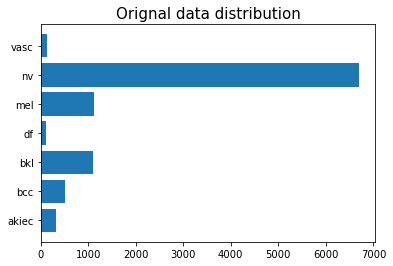

In [15]:
## showing distribution
parts = np.unique(TARGET)
count=[]
for part in parts:
    count.append(TARGET.count(part))
plt.barh(parts,count)
plt.title("Orignal data distribution",size = 15)
plt.show()

Text(0.5, 0, 'nv             mel               bcc  ')

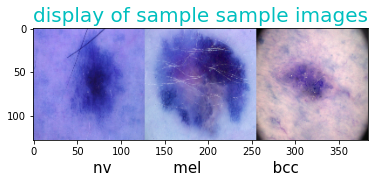

In [16]:
im_sample=np.concatenate((IMAGE[0],IMAGE[5010],IMAGE[10000]),axis=1)
plt.imshow(im_sample)
plt.title("display of sample sample images",size=20,color="c")
plt.xlabel("{}             {}               {}  ".format(TARGET[0],TARGET[5010],TARGET[10000]),size=15)

In [17]:
# RENAMING TARGET LABELS so TARGET CAN WORK WITH A CLASSIFIER ALOGRITHM
def re_label(targets):
    TAR=[]
    for part in targets:
        if part == 'akiec':
            TAR.append(0)
        elif part == 'bcc':
            TAR.append(1)
        elif part == 'bkl':
            TAR.append(2)
        elif part == 'df':
            TAR.append(3)
        elif part == 'mel':
            TAR.append(4)
        elif part == 'nv':
            TAR.append(5)
        else:
            TAR.append(6)
    return (TAR)
TARo = re_label(TARGET)


## reverse np labels
def revs_label(np_targets):
    Target=[]
    for part in np_targets:
        if part[0] == 1:
            Target.append('akiec')
        elif part[1] == 1:
            Target.append('bcc')
        elif part[2] == 1:
            Target.append('bkl')
        elif part[3] == 1:
            Target.append('df')
        elif part[4] == 1:
            Target.append('mel')
        elif part[5] == 1:
            Target.append('nv')
        elif part[6] == 1:
            Target.append('vasc')
    return (Target)

#### CREATING MAIN TEST SET 20% DATASET

In [18]:
# CREATING MAIN TEST SET 10% DATASET
# also setting  seed (for reproducibility)
np.random.seed(101)

IMAGES,IMAGES_Test,TAR_Train,TARGET_Test = train_test_split(IMAGE,TARo,stratify=TARo,test_size=0.2)



# reshaping data for Neural Network
IMAGES = np.array(IMAGES,dtype='float64').reshape(len(IMAGES), 128, 128, 3)

IMAGES_Test = np.array(IMAGES_Test,dtype='float64').reshape(len(IMAGES_Test), 128, 128, 3)

# changing labels to array like categorical labels vital for CNN training
TAR = np_utils.to_categorical(TAR_Train, 7)
TAR_Test = np_utils.to_categorical(TARGET_Test, 7)  # creating categorical output for test data


# normalising
IMAGES_Test /= 255
IMAGES /= 255

### Active Learning Framework
![framework](https://lh3.googleusercontent.com/pw/ADCreHfv_sTcap6jvYUnrJAF1iiek6uTFg0YbC0H8ZHD8pBv_ot5anLv8nfoLsomcl89eUgBfGHQ5K5r3zAFU8OmDk70RktxUNKHxu85jeOKLdgYIKPBMFQZjDD3Uf749_xJiDT_Y93DEtS_626VaYU9VoeL0x4efdotWzbbxTCriWrvxgVXBGWmO376B7sIPnqmlPZT2hWTFNEiPGcTBUjjHqj9lWWqKVjYxIQ5Dwp-RSz5KXEpmaXm8yatejtmzEqVcp1BhFkCets5cfkEeXlE-9dj9r_NzG_rf4AFi8tNL3QS5XEffhbRhEkxF5o3EQuOrT4U2YA-fqqRA5UT0ExaKsRLIJC7L6C8SjAtZLiOTrjvzU8UxA0Ou-onw0aPtqm4HJwQyJTpXOA_f_PcjF_ty02575dajPCSFNd_AWFgM6qMZPDxUsHqmQjoBbqOdKwVWmS0dPksacbdWZqWelX6XumcX1gDr-cqInbsY4Y1Ass8cxeZ7CDa5dtkpltX7g2-7k_vVvKj6i_GNnx_kxqdBJPQ79x-rw2AYVppINVGWpKZq0U0TLUHwCsYVefyisyEPPtrV-ay7P0PD2pLwXDnTBOWlYDiVktTJ2j9kTOUsKFD0hNe7bBpj8r3Zn-zC8SnIvvQ7_OCDoeOWS17Awd9S6MKdJLqWEclUU4i6EgKeb5VElwZL4gexJfxmY2-VfnyG8v0eJUZb-mO-zQMPATOMSYIKb835KZD5Mp2JLJbaRMwNsHpRUvfD5aOdN_mnpe8mNRK77-JDdvMXZ9rVCKaGI1l6cUusL42toNER-d_nbT4HLFh6jYFB-zSc-jKKuUIR9Jdy7zVFELwqcOKl9Z9Ybd1fYbQtvp59Q1dvjVdHzTw-HNqQReWEJrEBnZt_89Il1E9_G96yv5t72Zs806kSyFTH4Ca_sm07IUnLhsWeYbL9iU2eUMO_Wzbh1KVXA=w1728-h816-s-no?authuser=0)



<a id='random'></a>
### RANDOM SAMPLING

#### Active Learning 
**Require :**
1. initial labeled set for training ***L***
2. Unlabeled for test ***U***
4. get RANDOM batch to be query ***x_batch*** and get ***y*** from ORACLE ***O*** 
5. add ***x_batch*** to Labeled training set ***L*** (instance and target)
6. remove ***x_batch*** from Unlabeled ***U***
7. retraining model ***Mo***
8. testing certain batch and checking influence on retrain
9. reach final model ***M***


In [19]:
# AL Random Sample batch selection function
import random

def get_random_batch(percent):
    Per = round(len(TAR)*percent/100)
    try:
        batch = random.sample(range(0, len(IMAGES_U)), Per)
    except Exception as e:
        print("not enough samples left or {}".format(e))
        batch = random.sample(range(0, len(IMAGES_U)), len(IMAGES_U))
    return(batch)

### Initializing with 10% Labeled Training Set

In [20]:
np.random.seed(101)
r = 0.1  # 10% START TRAINING SET
IMAGES_L,IMAGES_U,TARGET_L,TARGET_O = train_test_split(IMAGES,TAR,stratify=TAR,test_size=(1-r))

print("RANDOM SAMPLED START TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

# IMAGES_L: initial labeled set for training L
# IMAGES_U: Unlabeled for pool U
# TARGET_L: corresponding target for L
# TARGET_O: ORACLE for Unlabeled pool U

RANDOM SAMPLED START TRAINING SET AT 10%


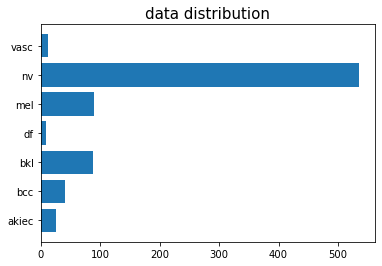

In [21]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

### Baseline Model
#### from pre-trained DenseNet201 

In [22]:

modelR = Sequential()

pretrained_model_for_demo= tf.keras.applications.DenseNet201(
    include_top=False,
    input_shape=(128,128,3),
    pooling='avg',
    classes=1000,
    weights='imagenet',
)                     # 

for each_layer in pretrained_model_for_demo.layers[:-25]:  # 20 BOTH 78%

        each_layer.trainable=False                             # runs a for loop to change setting on layers in model not to retrain

modelR.add(pretrained_model_for_demo)


modelR.add(Flatten())

modelR.add(Dense(512, activation='relu'))

modelR.add(Dense(7, activation="softmax"))

modelR.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
# TEN 10% TRAINING

modelR.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) 


Epoch 1/12
41/41 [==============================] - 82s 1s/step - loss: 1.2711 - accuracy: 0.6467
Epoch 2/12
41/41 [==============================] - 65s 2s/step - loss: 0.6715 - accuracy: 0.7803
Epoch 3/12
41/41 [==============================] - 74s 2s/step - loss: 0.4672 - accuracy: 0.8352
Epoch 4/12
41/41 [==============================] - 67s 2s/step - loss: 0.4367 - accuracy: 0.8277
Epoch 5/12
41/41 [==============================] - 65s 2s/step - loss: 0.1710 - accuracy: 0.9451
Epoch 6/12
41/41 [==============================] - 68s 2s/step - loss: 0.1085 - accuracy: 0.9663
Epoch 7/12
41/41 [==============================] - 71s 2s/step - loss: 0.3897 - accuracy: 0.8851
Epoch 8/12
41/41 [==============================] - 65s 2s/step - loss: 0.0589 - accuracy: 0.9825
Epoch 9/12
41/41 [==============================] - 65s 2s/step - loss: 0.0685 - accuracy: 0.9788
Epoch 10/12
41/41 [==============================] - 63s 2s/step - loss: 0.0312 - accuracy: 0.9950
Epoch 11/12
41/41 [

In [24]:
# TESTING
predR = modelR.predict(IMAGES_Test)
pred_test=[]
for x in predR:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

error = 0
for i in range(len(TAR_Test)):
    if str(TAR_Test[i])!=str(pred_test[i]):
        error+=1
test_accuracy = 1-error/len(TAR_Test)
print("test accuracy = ", test_accuracy)

print(classification_report(TAR_Test, pred_test))


test accuracy =  0.6320519221168248
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.53      0.18      0.27       103
           2       0.24      0.66      0.35       220
           3       0.00      0.00      0.00        23
           4       0.47      0.33      0.39       223
           5       0.90      0.76      0.82      1341
           6       0.69      0.32      0.44        28

   micro avg       0.65      0.63      0.64      2003
   macro avg       0.40      0.32      0.32      2003
weighted avg       0.72      0.63      0.65      2003
 samples avg       0.63      0.63      0.63      2003



C:\Users\program_AD\anaconda3\envs\pro_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\program_AD\anaconda3\envs\pro_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### ADDING RANDOM BATCH TO TRAINING SET 
##### AT 20%

In [25]:
# GETTING AND ADDING NEXT BATCH

batch = get_random_batch(10)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

In [26]:
# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

RANDOM SAMPLED NOW TRAINING SET AT 20%


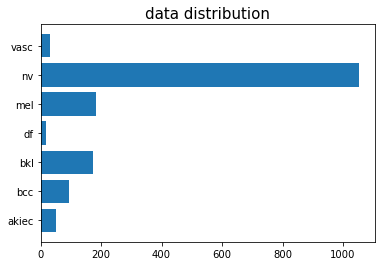

In [27]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [28]:
# TEN 20% TRAINING

modelR.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) 


Epoch 1/12
81/81 [==============================] - 131s 2s/step - loss: 0.8134 - accuracy: 0.7840
Epoch 2/12
81/81 [==============================] - 130s 2s/step - loss: 0.3383 - accuracy: 0.8901
Epoch 3/12
81/81 [==============================] - 136s 2s/step - loss: 0.2166 - accuracy: 0.9251
Epoch 4/12
81/81 [==============================] - 131s 2s/step - loss: 0.1071 - accuracy: 0.9644
Epoch 5/12
81/81 [==============================] - 132s 2s/step - loss: 0.1049 - accuracy: 0.9644
Epoch 6/12
81/81 [==============================] - 132s 2s/step - loss: 0.1897 - accuracy: 0.9338
Epoch 7/12
81/81 [==============================] - 131s 2s/step - loss: 0.0729 - accuracy: 0.9750
Epoch 8/12
81/81 [==============================] - 136s 2s/step - loss: 0.0707 - accuracy: 0.9750
Epoch 9/12
81/81 [==============================] - 138s 2s/step - loss: 0.1224 - accuracy: 0.9588
Epoch 10/12
81/81 [==============================] - 137s 2s/step - loss: 0.0773 - accuracy: 0.9725
Epoch 11/

In [29]:
# TESTING
predR = modelR.predict(IMAGES_Test)
pred_test=[]
for x in predR:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

error = 0
for i in range(len(TAR_Test)):
    if str(TAR_Test[i])!=str(pred_test[i]):
        error+=1
test_accuracy = 1-error/len(TAR_Test)
print("test accuracy = ", test_accuracy)

print(classification_report(TAR_Test, pred_test))


test accuracy =  0.7119321018472291
              precision    recall  f1-score   support

           0       0.44      0.12      0.19        65
           1       0.45      0.35      0.39       103
           2       0.41      0.44      0.42       220
           3       0.09      0.13      0.11        23
           4       0.44      0.42      0.43       223
           5       0.87      0.88      0.87      1341
           6       0.63      0.43      0.51        28

   micro avg       0.73      0.71      0.72      2003
   macro avg       0.48      0.40      0.42      2003
weighted avg       0.72      0.71      0.71      2003
 samples avg       0.71      0.71      0.71      2003



C:\Users\program_AD\anaconda3\envs\pro_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### ADDING NEXT RANDOM BATCH TO TRAINING SET 
##### AT 30%

In [30]:
# GETTING AND ADDING NEXT BATCH

batch = get_random_batch(10)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

RANDOM SAMPLED NOW TRAINING SET AT 30%


In [31]:
# TEN 30% TRAINING

modelR.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) 


Epoch 1/12
121/121 [==============================] - 219s 2s/step - loss: 0.3802 - accuracy: 0.8893
Epoch 2/12
121/121 [==============================] - 205s 2s/step - loss: 0.1881 - accuracy: 0.9367
Epoch 3/12
121/121 [==============================] - 198s 2s/step - loss: 0.1038 - accuracy: 0.9638
Epoch 4/12
121/121 [==============================] - 203s 2s/step - loss: 0.1036 - accuracy: 0.9630
Epoch 5/12
121/121 [==============================] - 193s 2s/step - loss: 0.0880 - accuracy: 0.9705
Epoch 6/12
121/121 [==============================] - 192s 2s/step - loss: 0.0738 - accuracy: 0.9754
Epoch 7/12
121/121 [==============================] - 196s 2s/step - loss: 0.0400 - accuracy: 0.9846
Epoch 8/12
121/121 [==============================] - 200s 2s/step - loss: 0.1026 - accuracy: 0.9684
Epoch 9/12
121/121 [==============================] - 198s 2s/step - loss: 0.0597 - accuracy: 0.9796
Epoch 10/12
121/121 [==============================] - 198s 2s/step - loss: 0.0596 - accura

In [32]:
# TESTING
predR = modelR.predict(IMAGES_Test)
pred_test=[]
for x in predR:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

error = 0
for i in range(len(TAR_Test)):
    if str(TAR_Test[i])!=str(pred_test[i]):
        error+=1
test_accuracy = 1-error/len(TAR_Test)
print("test accuracy = ", test_accuracy)

print(classification_report(TAR_Test, pred_test))


test accuracy =  0.7314028956565153
              precision    recall  f1-score   support

           0       0.38      0.37      0.37        65
           1       0.42      0.54      0.48       103
           2       0.50      0.41      0.45       220
           3       0.44      0.17      0.25        23
           4       0.44      0.40      0.42       223
           5       0.87      0.89      0.88      1341
           6       0.78      0.25      0.38        28

   micro avg       0.74      0.73      0.74      2003
   macro avg       0.55      0.43      0.46      2003
weighted avg       0.74      0.73      0.73      2003
 samples avg       0.73      0.73      0.73      2003



C:\Users\program_AD\anaconda3\envs\pro_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 40% 

In [33]:
# GETTING AND ADDING NEXT BATCH

batch = get_random_batch(10)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

RANDOM SAMPLED NOW TRAINING SET AT 40%


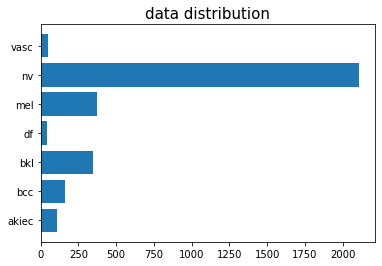

In [34]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [35]:
# TEN 40% TRAINING

modelR.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) 


Epoch 1/12
161/161 [==============================] - 264s 2s/step - loss: 0.3298 - accuracy: 0.9067
Epoch 2/12
161/161 [==============================] - 269s 2s/step - loss: 0.1704 - accuracy: 0.9448
Epoch 3/12
161/161 [==============================] - 258s 2s/step - loss: 0.0987 - accuracy: 0.9688
Epoch 4/12
161/161 [==============================] - 242s 2s/step - loss: 0.0739 - accuracy: 0.9757
Epoch 5/12
161/161 [==============================] - 240s 1s/step - loss: 0.1411 - accuracy: 0.9488
Epoch 6/12
161/161 [==============================] - 239s 1s/step - loss: 0.0964 - accuracy: 0.9647
Epoch 7/12
161/161 [==============================] - 243s 2s/step - loss: 0.0394 - accuracy: 0.9885
Epoch 8/12
161/161 [==============================] - 240s 1s/step - loss: 0.0316 - accuracy: 0.9897
Epoch 9/12
161/161 [==============================] - 238s 1s/step - loss: 0.0415 - accuracy: 0.9850
Epoch 10/12
161/161 [==============================] - 243s 2s/step - loss: 0.0589 - accura

In [36]:
# TESTING
predR = modelR.predict(IMAGES_Test)
pred_test=[]
for x in predR:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

error = 0
for i in range(len(TAR_Test)):
    if str(TAR_Test[i])!=str(pred_test[i]):
        error+=1
test_accuracy = 1-error/len(TAR_Test)
print("test accuracy = ", test_accuracy)

print(classification_report(TAR_Test, pred_test))


test accuracy =  0.7428856714927609
              precision    recall  f1-score   support

           0       0.65      0.20      0.31        65
           1       0.62      0.50      0.56       103
           2       0.44      0.52      0.48       220
           3       0.38      0.22      0.28        23
           4       0.44      0.47      0.45       223
           5       0.88      0.88      0.88      1341
           6       0.76      0.46      0.58        28

   micro avg       0.75      0.74      0.75      2003
   macro avg       0.60      0.47      0.50      2003
weighted avg       0.75      0.74      0.74      2003
 samples avg       0.74      0.74      0.74      2003



C:\Users\program_AD\anaconda3\envs\pro_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 50%

In [37]:
# GETTING AND ADDING NEXT BATCH

batch = get_random_batch(10)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

RANDOM SAMPLED NOW TRAINING SET AT 50%


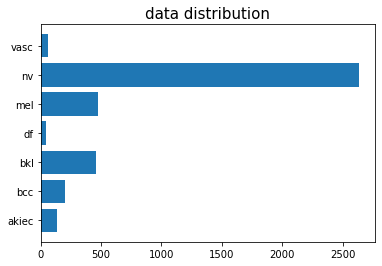

In [38]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [39]:
# TEN 50% TRAINING

modelR.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) 


Epoch 1/12
201/201 [==============================] - 328s 2s/step - loss: 0.2208 - accuracy: 0.9423
Epoch 2/12
201/201 [==============================] - 329s 2s/step - loss: 0.0964 - accuracy: 0.9683
Epoch 3/12
201/201 [==============================] - 327s 2s/step - loss: 0.0698 - accuracy: 0.9765
Epoch 4/12
201/201 [==============================] - 330s 2s/step - loss: 0.0594 - accuracy: 0.9795
Epoch 5/12
201/201 [==============================] - 336s 2s/step - loss: 0.0492 - accuracy: 0.9835
Epoch 6/12
201/201 [==============================] - 327s 2s/step - loss: 0.0407 - accuracy: 0.9853
Epoch 7/12
201/201 [==============================] - 316s 2s/step - loss: 0.0502 - accuracy: 0.9833
Epoch 8/12
201/201 [==============================] - 326s 2s/step - loss: 0.0473 - accuracy: 0.9855
Epoch 9/12
201/201 [==============================] - 323s 2s/step - loss: 0.0507 - accuracy: 0.9838
Epoch 10/12
201/201 [==============================] - 322s 2s/step - loss: 0.0463 - accura

In [40]:
# TESTING
predR = modelR.predict(IMAGES_Test)
pred_test=[]
for x in predR:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

error = 0
for i in range(len(TAR_Test)):
    if str(TAR_Test[i])!=str(pred_test[i]):
        error+=1
test_accuracy = 1-error/len(TAR_Test)
print("test accuracy = ", test_accuracy)

print(classification_report(TAR_Test, pred_test))


test accuracy =  0.7428856714927609
              precision    recall  f1-score   support

           0       0.38      0.29      0.33        65
           1       0.53      0.56      0.55       103
           2       0.55      0.37      0.44       220
           3       0.00      0.00      0.00        23
           4       0.41      0.55      0.47       223
           5       0.88      0.89      0.89      1341
           6       0.64      0.50      0.56        28

   micro avg       0.75      0.74      0.75      2003
   macro avg       0.48      0.45      0.46      2003
weighted avg       0.74      0.74      0.74      2003
 samples avg       0.74      0.74      0.74      2003



C:\Users\program_AD\anaconda3\envs\pro_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# 60% 

In [42]:
# GETTING AND ADDING NEXT BATCH

batch = get_random_batch(10)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

RANDOM SAMPLED NOW TRAINING SET AT 60%


In [43]:
# TEN 60% TRAINING

modelR.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) 


Epoch 1/12
241/241 [==============================] - 436s 2s/step - loss: 0.2290 - accuracy: 0.9378
Epoch 2/12
241/241 [==============================] - 380s 2s/step - loss: 0.0959 - accuracy: 0.9705
Epoch 3/12
241/241 [==============================] - 388s 2s/step - loss: 0.0585 - accuracy: 0.9821
Epoch 4/12
241/241 [==============================] - 389s 2s/step - loss: 0.0458 - accuracy: 0.9861
Epoch 5/12
241/241 [==============================] - 361s 1s/step - loss: 0.0389 - accuracy: 0.9879
Epoch 6/12
241/241 [==============================] - 372s 2s/step - loss: 0.0421 - accuracy: 0.9861
Epoch 7/12
241/241 [==============================] - 363s 2s/step - loss: 0.0350 - accuracy: 0.9869
Epoch 8/12
241/241 [==============================] - 368s 2s/step - loss: 0.0577 - accuracy: 0.9806
Epoch 9/12
241/241 [==============================] - 368s 2s/step - loss: 0.0482 - accuracy: 0.9825
Epoch 10/12
241/241 [==============================] - 352s 1s/step - loss: 0.0297 - accura

In [44]:
# TESTING
predR = modelR.predict(IMAGES_Test)
pred_test=[]
for x in predR:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

error = 0
for i in range(len(TAR_Test)):
    if str(TAR_Test[i])!=str(pred_test[i]):
        error+=1
test_accuracy = 1-error/len(TAR_Test)
print("test accuracy = ", test_accuracy)

print(classification_report(TAR_Test, pred_test))


test accuracy =  0.7553669495756365
              precision    recall  f1-score   support

           0       0.48      0.25      0.33        65
           1       0.50      0.58      0.54       103
           2       0.53      0.41      0.47       220
           3       0.20      0.04      0.07        23
           4       0.58      0.32      0.41       223
           5       0.84      0.94      0.89      1341
           6       0.62      0.46      0.53        28

   micro avg       0.77      0.76      0.76      2003
   macro avg       0.54      0.43      0.46      2003
weighted avg       0.74      0.76      0.74      2003
 samples avg       0.76      0.76      0.76      2003



C:\Users\program_AD\anaconda3\envs\pro_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 70% 

In [ ]:
# GETTING AND ADDING NEXT BATCH

batch = get_random_batch(10)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

RANDOM SAMPLED NOW TRAINING SET AT 70%


In [ ]:
# TEN 70% TRAINING

modelR.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) 


Epoch 1/12
281/281 [==============================] - 8s 29ms/step - loss: 0.1936 - accuracy: 0.9513
Epoch 2/12
281/281 [==============================] - 6s 23ms/step - loss: 0.0796 - accuracy: 0.9749
Epoch 3/12
281/281 [==============================] - 6s 23ms/step - loss: 0.0446 - accuracy: 0.9847
Epoch 4/12
281/281 [==============================] - 6s 22ms/step - loss: 0.0379 - accuracy: 0.9868
Epoch 5/12
281/281 [==============================] - 6s 23ms/step - loss: 0.0350 - accuracy: 0.9875
Epoch 6/12
281/281 [==============================] - 6s 23ms/step - loss: 0.0429 - accuracy: 0.9866
Epoch 7/12
281/281 [==============================] - 6s 23ms/step - loss: 0.0484 - accuracy: 0.9845
Epoch 8/12
281/281 [==============================] - 6s 22ms/step - loss: 0.0322 - accuracy: 0.9897
Epoch 9/12
281/281 [==============================] - 6s 23ms/step - loss: 0.0295 - accuracy: 0.9911
Epoch 10/12
281/281 [==============================] - 6s 23ms/step - loss: 0.0365 - accura

In [ ]:
# TESTING
predR = modelR.predict(IMAGES_Test)
pred_test=[]
for x in predR:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

error = 0
for i in range(len(TAR_Test)):
    if str(TAR_Test[i])!=str(pred_test[i]):
        error+=1
test_accuracy = 1-error/len(TAR_Test)
print("test accuracy = ", test_accuracy)

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 18ms/step
test accuracy =  0.7688467299051422
              precision    recall  f1-score   support

           0       0.37      0.28      0.32        65
           1       0.53      0.48      0.50       103
           2       0.62      0.44      0.51       220
           3       0.29      0.39      0.33        23
           4       0.56      0.40      0.46       223
           5       0.86      0.94      0.90      1341
           6       0.67      0.71      0.69        28

   micro avg       0.78      0.77      0.77      2003
   macro avg       0.56      0.52      0.53      2003
weighted avg       0.76      0.77      0.76      2003
 samples avg       0.77      0.77      0.77      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 80% 

In [ ]:
# GETTING AND ADDING NEXT BATCH

batch = get_random_batch(10)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

RANDOM SAMPLED NOW TRAINING SET AT 80%


In [ ]:
# TEN 10% TRAINING

modelR.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) 


Epoch 1/12
321/321 [==============================] - 9s 28ms/step - loss: 0.1782 - accuracy: 0.9527
Epoch 2/12
321/321 [==============================] - 7s 22ms/step - loss: 0.0821 - accuracy: 0.9767
Epoch 3/12
321/321 [==============================] - 7s 23ms/step - loss: 0.0412 - accuracy: 0.9877
Epoch 4/12
321/321 [==============================] - 7s 22ms/step - loss: 0.0380 - accuracy: 0.9867
Epoch 5/12
321/321 [==============================] - 7s 23ms/step - loss: 0.0300 - accuracy: 0.9892
Epoch 6/12
321/321 [==============================] - 7s 22ms/step - loss: 0.0368 - accuracy: 0.9875
Epoch 7/12
321/321 [==============================] - 7s 23ms/step - loss: 0.0175 - accuracy: 0.9947
Epoch 8/12
321/321 [==============================] - 7s 23ms/step - loss: 0.0277 - accuracy: 0.9903
Epoch 9/12
321/321 [==============================] - 7s 22ms/step - loss: 0.0461 - accuracy: 0.9839
Epoch 10/12
321/321 [==============================] - 7s 23ms/step - loss: 0.0344 - accura

In [ ]:
# TESTING
predR = modelR.predict(IMAGES_Test)
pred_test=[]
for x in predR:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

error = 0
for i in range(len(TAR_Test)):
    if str(TAR_Test[i])!=str(pred_test[i]):
        error+=1
test_accuracy = 1-error/len(TAR_Test)
print("test accuracy = ", test_accuracy)

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 17ms/step
test accuracy =  0.7838242636045931
              precision    recall  f1-score   support

           0       0.42      0.35      0.38        65
           1       0.53      0.53      0.53       103
           2       0.61      0.55      0.58       220
           3       0.29      0.26      0.27        23
           4       0.64      0.43      0.51       223
           5       0.87      0.93      0.90      1341
           6       0.87      0.71      0.78        28

   micro avg       0.79      0.78      0.79      2003
   macro avg       0.60      0.54      0.57      2003
weighted avg       0.78      0.78      0.78      2003
 samples avg       0.78      0.78      0.78      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 90% 


In [ ]:
# GETTING AND ADDING NEXT BATCH

batch = get_random_batch(10)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

RANDOM SAMPLED NOW TRAINING SET AT 90%


In [ ]:
# TEN 10% TRAINING

modelR.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) 


Epoch 1/12
361/361 [==============================] - 10s 28ms/step - loss: 0.1736 - accuracy: 0.9609
Epoch 2/12
361/361 [==============================] - 8s 23ms/step - loss: 0.0690 - accuracy: 0.9806
Epoch 3/12
361/361 [==============================] - 8s 22ms/step - loss: 0.0557 - accuracy: 0.9842
Epoch 4/12
361/361 [==============================] - 8s 23ms/step - loss: 0.0374 - accuracy: 0.9875
Epoch 5/12
361/361 [==============================] - 8s 23ms/step - loss: 0.0349 - accuracy: 0.9889
Epoch 6/12
361/361 [==============================] - 8s 22ms/step - loss: 0.0280 - accuracy: 0.9907
Epoch 7/12
361/361 [==============================] - 8s 23ms/step - loss: 0.0453 - accuracy: 0.9831
Epoch 8/12
361/361 [==============================] - 8s 23ms/step - loss: 0.0239 - accuracy: 0.9920
Epoch 9/12
361/361 [==============================] - 8s 22ms/step - loss: 0.0279 - accuracy: 0.9897
Epoch 10/12
361/361 [==============================] - 8s 23ms/step - loss: 0.0312 - accur

In [ ]:
# TESTING
predR = modelR.predict(IMAGES_Test)
pred_test=[]
for x in predR:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

error = 0
for i in range(len(TAR_Test)):
    if str(TAR_Test[i])!=str(pred_test[i]):
        error+=1
test_accuracy = 1-error/len(TAR_Test)
print("test accuracy = ", test_accuracy)

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 18ms/step
test accuracy =  0.7673489765351972
              precision    recall  f1-score   support

           0       0.58      0.28      0.38        65
           1       0.49      0.63      0.55       103
           2       0.61      0.50      0.55       220
           3       0.56      0.43      0.49        23
           4       0.48      0.48      0.48       223
           5       0.89      0.90      0.90      1341
           6       0.58      0.75      0.66        28

   micro avg       0.78      0.77      0.77      2003
   macro avg       0.60      0.57      0.57      2003
weighted avg       0.78      0.77      0.77      2003
 samples avg       0.77      0.77      0.77      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 100%
### Benchmark : DenseNet keras pretrained (imagenet)

In [ ]:
t = time.perf_counter()
modelR.fit(IMAGES,np.array(TAR),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow
t1 = time.perf_counter() - t

Epoch 1/12
401/401 [==============================] - 11s 27ms/step - loss: 0.1490 - accuracy: 0.9647
Epoch 2/12
401/401 [==============================] - 9s 23ms/step - loss: 0.0685 - accuracy: 0.9819
Epoch 3/12
401/401 [==============================] - 9s 23ms/step - loss: 0.0342 - accuracy: 0.9886
Epoch 4/12
401/401 [==============================] - 9s 23ms/step - loss: 0.0259 - accuracy: 0.9910
Epoch 5/12
401/401 [==============================] - 9s 22ms/step - loss: 0.0349 - accuracy: 0.9870
Epoch 6/12
401/401 [==============================] - 9s 23ms/step - loss: 0.0308 - accuracy: 0.9893
Epoch 7/12
401/401 [==============================] - 9s 23ms/step - loss: 0.0283 - accuracy: 0.9908
Epoch 8/12
401/401 [==============================] - 9s 22ms/step - loss: 0.0208 - accuracy: 0.9938
Epoch 9/12
401/401 [==============================] - 9s 23ms/step - loss: 0.0387 - accuracy: 0.9883
Epoch 10/12
401/401 [==============================] - 9s 23ms/step - loss: 0.0267 - accur

#### the testing



In [ ]:
# the prediction are stored as floats in array. code below extract it to integers in a list
pred = modelR.predict(IMAGES_Test)
pred_test=[]
for x in pred:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

error = 0
for i in range(len(TAR_Test)):
    if str(TAR_Test[i])!=str(pred_test[i]):
        error+=1
test_accuracy = 1-error/len(TAR_Test)
print("test accuracy = ", test_accuracy)

63/63 [==============================] - 1s 18ms/step
test accuracy =  0.763854218671992


In [ ]:
breport = classification_report(TAR_Test, pred_test)
print(classification_report(TAR_Test, pred_test))


              precision    recall  f1-score   support

           0       0.46      0.43      0.44        65
           1       0.66      0.44      0.53       103
           2       0.55      0.58      0.56       220
           3       0.54      0.30      0.39        23
           4       0.47      0.52      0.49       223
           5       0.88      0.89      0.88      1341
           6       0.94      0.57      0.71        28

   micro avg       0.77      0.76      0.77      2003
   macro avg       0.64      0.53      0.57      2003
weighted avg       0.77      0.76      0.77      2003
 samples avg       0.76      0.76      0.76      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id='uncertainty'></a>
## UNCERTAINTY SAMPLING

# content
   1. [Import Library and mount google drive](#importing_libraries)
   2. [Load HAM10K data set to memory](#loading_dataset)
   3. [Describe general Active learn Process Flow](#process_flow)
   4. [Defining Uncertainty Strategy function and base line CNN model](#function)
   5. [8*RUNS of experiment for statistical confidence](#runs)
       * reset train/test split 
       * starting from 10% 
       * test on testset at every step and document result

       

<a id='importing_libraries'></a>
### IMPORTING SOME LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib 
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
# ADDING THE LAST TRANINABLE LAYER
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,ZeroPadding2D,Input #importing some cool keras layers 1st
import random

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:

os.chdir('gdrive/MyDrive/3PROJECT')
#os.listdir()
#os.getcwd()

<a id='loading_dataset'></a>
### HAM10000 DATASET LOAD

APPROACH A: load data in from both folders in to a REPO in script memory

then while loading each file; match file name with csv and load Target to a TAR file also in memory

In [ ]:
# reading target source file into dataframe
skin_df = pd.read_csv('HAM10000/HAM10000_metadata.csv')

In [ ]:
# this data is stored in a local directory "HAM10000"
# using os to locate files and cv2 to read into Numpy arrays
resize_width = 128
resize_height = 128
path = "HAM10000"
IMAGE = [] # List to append the images as 2D numpy arrays.
TARGET = [] # List to append the target all ch


for root, dirs, files in os.walk(path):
     for file in files:
         if '(1)' not in file:
             with open(os.path.join(root, file), "r") as auto:
                 try:
              
                     img = cv2.imread(root+'/'+file)   # cv2 reads image to a 2d ie grayscale=0 full_RGB = _default_blank_
                     img = cv2.resize(img, (resize_width, resize_height)) # image resize to 128/128
                     IMAGE.append(img)
                     # Append the folder where the image is to the target list
                     TARGET.append(list(skin_df.dx[skin_df.image_id == file.replace('.jpg','')])[0])
                 except Exception as e:
                     print("Invalid file "+file+" skipped.")

for part in np.unique(TARGET):
    print ('{} has {} images'.format(part,TARGET.count(part)))
print("TOTAL IMAGES =",len(TARGET))

Invalid file HAM10000_metadata.csv skipped.
Invalid file hmnist_28_28_L.csv skipped.
Invalid file hmnist_8_8_L.csv skipped.
Invalid file hmnist_8_8_RGB.csv skipped.
Invalid file hmnist_28_28_RGB.csv skipped.
akiec has 327 images
bcc has 514 images
bkl has 1099 images
df has 115 images
mel has 1113 images
nv has 6705 images
vasc has 142 images
TOTAL IMAGES = 10015


In [ ]:
IMAGE[0].shape

(128, 128, 3)

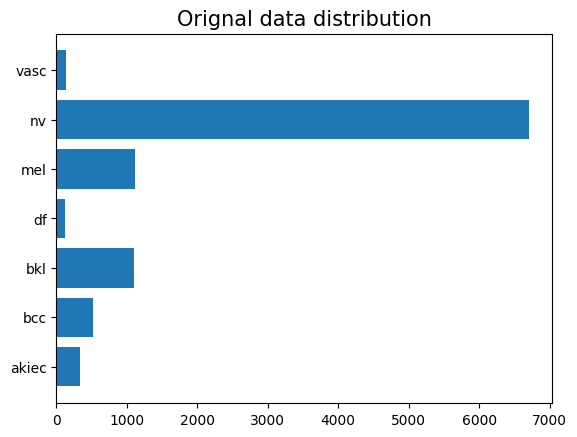

In [ ]:
## showing distribution
parts = np.unique(TARGET)
count=[]
for part in parts:
    count.append(TARGET.count(part))
plt.barh(parts,count)
plt.title("Orignal data distribution",size = 15)
plt.show()

Text(0.5, 0, 'nv             nv               nv  ')

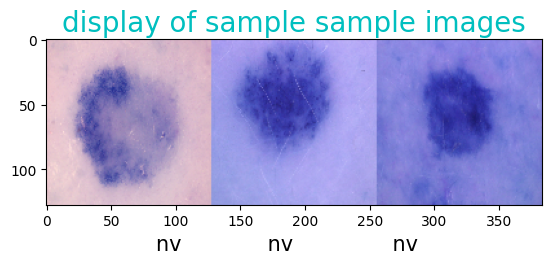

In [ ]:
im_sample=np.concatenate((IMAGE[0],IMAGE[5010],IMAGE[10000]),axis=1)
plt.imshow(im_sample)
plt.title("display of sample sample images",size=20,color="c")
plt.xlabel("{}             {}               {}  ".format(TARGET[0],TARGET[5010],TARGET[10000]),size=15)

In [ ]:
# RENAMING TARGET LABELS so TARGET CAN WORK WITH A CLASSIFIER ALOGRITHM
def re_label(targets):
    TAR=[]
    for part in targets:
        if part == 'akiec':
            TAR.append(0)
        elif part == 'bcc':
            TAR.append(1)
        elif part == 'bkl':
            TAR.append(2)
        elif part == 'df':
            TAR.append(3)
        elif part == 'mel':
            TAR.append(4)
        elif part == 'nv':
            TAR.append(5)
        else:
            TAR.append(6)
    return (TAR)
TARo = re_label(TARGET)

## reverse np labels
def revs_label(np_targets):
    Target=[]
    for part in np_targets:
        if part[0] == 1:
            Target.append('akiec')
        elif part[1] == 1:
            Target.append('bcc')
        elif part[2] == 1:
            Target.append('bkl')
        elif part[3] == 1:
            Target.append('df')
        elif part[4] == 1:
            Target.append('mel')
        elif part[5] == 1:
            Target.append('nv')
        elif part[6] == 1:
            Target.append('vasc')
    return (Target)

In [ ]:
# CONFUSION MATRIX FUNCTION
def plot_confusion_matrix(y_test,y_scores, classNames):
    y_test=np.argmax(y_test, axis=1)
    y_scores=np.argmax(y_scores, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]/np.sum(cm[x,:])

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1) # for label size
    df = sns.heatmap(con, annot=True,fmt='.2', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
classNames = ['akiec','bcc','bkl','df','mel','nv','vasc'] 
# source https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels

##### splitting the data

In [ ]:
# CREATING MAIN TEST SET 10% DATASET
# also setting  seed (for reproducibility)
np.random.seed(101)

IMAGES,IMAGES_Test,TAR_Train,TARGET_Test_M = train_test_split(IMAGE,TARo,stratify=TARo,test_size=0.2)



# reshaping data for Neural Network
IMAGES = np.array(IMAGES,dtype='float64').reshape(len(IMAGES), 128, 128, 3)

IMAGES_Test = np.array(IMAGES_Test,dtype='float64').reshape(len(IMAGES_Test), 128, 128, 3)

# changing labels to array like categorical labels vital for CNN training
TAR = np_utils.to_categorical(TAR_Train, 7)
TAR_Test = np_utils.to_categorical(TARGET_Test_M, 7)  # creating categorical output for test data


# normalising
IMAGES_Test /= 255
IMAGES /= 255

![framework](CODE/framework.jpg)

<a id='process_flow'></a>
### ACTIVE LEARNING (AL) PROCESS FLOW 
**Require :**
1. initial labeled set for training ***IMAGES_L, TARGET_L***
2. Unlabeled for test ***IMAGES_U***
3. based on initial trained model ***ModelAL*** certain batch to be auto-label and absorbed
4. informative batch to be query ***x_batch*** and get ***y*** from ORACLE ***O_Target*** 
5. add ***x_batch*** to Labeled training set ***L*** (IMAGES and TARGET)
6. remove ***x_batch*** from Unlabeled ***IMAGES_U***
7. retraining model ***ModelAL***
8. testing model ***ModelAL***  on test set
9. reach final model ***M***


##### AL initialize with Random 10% Sample 

In [ ]:
np.random.seed(101)
r = 0.1  # 10% START TRAINING SET
IMAGES_L,IMAGES_U,TARGET_L,TARGET_O = train_test_split(IMAGES,TAR,stratify=TAR,test_size=(1-r))

print("RANDOM SAMPLED START TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

# IMAGES_L: initial labeled set for training L
# IMAGES_U: Unlabeled for pool U
# TARGET_L: corresponding target for L
# TARGET_O: ORACLE for Unlabeled pool U

RANDOM SAMPLED START TRAINING SET AT 10%


<a id='function'></a>
### Active Learn uncertainty Strategy Function



In [ ]:
## least CONFIDENCE
def get_active_batch(percent): 
    Per = len(TAR)*percent/100
    uncertainty = 1/7
    batch=[]
    
    while (len(batch) < Per)&(len(predAL)>Per):
        batch=[]
        for i in range (len(predAL)):
            y = predAL[i].max()
            if y < uncertainty: 
                batch.append(i)
        uncertainty+= 0.001
    return (batch)

#### Defining  MODELAL  to use same as pretrained DenseNet201

In [ ]:
# TEN 10% TRAINING

ALmodel = Sequential()

pretrained_model= tf.keras.applications.DenseNet201(
    include_top=False,
    input_shape=(128,128,3),
    pooling='avg',
    classes=1000,
    weights='imagenet',
)                     # 

for each_layer in pretrained_model.layers[:-25]:  # 20 BOTH 78%

        each_layer.trainable=False                             # runs a for loop to change setting on layers in model not to retrain

ALmodel.add(pretrained_model)


ALmodel.add(Flatten())

ALmodel.add(Dense(512, activation='relu'))

ALmodel.add(Dense(7, activation="softmax"))

ALmodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

74836368/74836368 [==============================] - 0s 0us/step


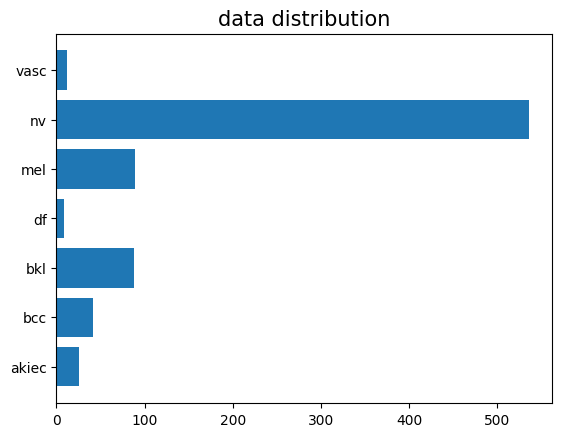

In [ ]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

<a id='runs'></a>
### UNCERTAINTY Start Run

In [ ]:
#reset model and compute with new active data
ALmodel.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1)
# to get fig for test at 10% from Random experiment

Epoch 1/12
41/41 [==============================] - 30s 74ms/step - loss: 1.2233 - accuracy: 0.6567
Epoch 2/12
41/41 [==============================] - 1s 26ms/step - loss: 0.6567 - accuracy: 0.7690
Epoch 3/12
41/41 [==============================] - 1s 27ms/step - loss: 0.5158 - accuracy: 0.8102
Epoch 4/12
41/41 [==============================] - 1s 27ms/step - loss: 0.5026 - accuracy: 0.8327
Epoch 5/12
41/41 [==============================] - 1s 27ms/step - loss: 0.3363 - accuracy: 0.8801
Epoch 6/12
41/41 [==============================] - 1s 27ms/step - loss: 0.1208 - accuracy: 0.9663
Epoch 7/12
41/41 [==============================] - 1s 27ms/step - loss: 0.1102 - accuracy: 0.9713
Epoch 8/12
41/41 [==============================] - 1s 27ms/step - loss: 0.2570 - accuracy: 0.9201
Epoch 9/12
41/41 [==============================] - 1s 27ms/step - loss: 0.0381 - accuracy: 0.9925
Epoch 10/12
41/41 [==============================] - 1s 27ms/step - loss: 0.0448 - accuracy: 0.9850
Epoch 11

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = ALmodel.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


226/226 [==============================] - 8s 21ms/step


In [ ]:
# 15% 

# GETTING AND ADDING NEXT BATCH

batch = get_active_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("SAMPLE NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

#### SAMPLE RATIO NOW AT 15%

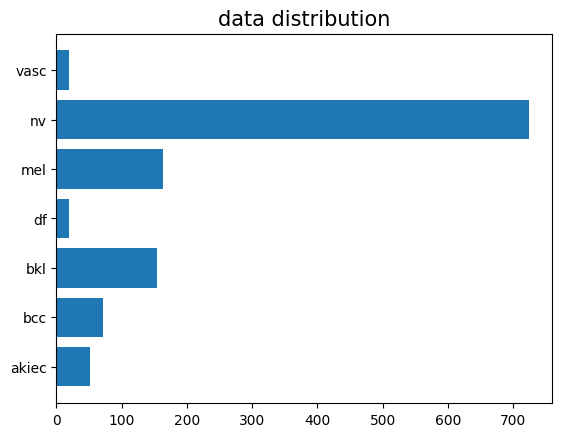

In [ ]:

## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
#reset model and compute with new active data
ALmodel.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1)

Epoch 1/12
61/61 [==============================] - 3s 56ms/step - loss: 0.7635 - accuracy: 0.7596
Epoch 2/12
61/61 [==============================] - 2s 27ms/step - loss: 0.3374 - accuracy: 0.8810
Epoch 3/12
61/61 [==============================] - 2s 27ms/step - loss: 0.2392 - accuracy: 0.9118
Epoch 4/12
61/61 [==============================] - 2s 27ms/step - loss: 0.0960 - accuracy: 0.9676
Epoch 5/12
61/61 [==============================] - 2s 26ms/step - loss: 0.2366 - accuracy: 0.9185
Epoch 6/12
61/61 [==============================] - 2s 27ms/step - loss: 0.2163 - accuracy: 0.9226
Epoch 7/12
61/61 [==============================] - 2s 27ms/step - loss: 0.1389 - accuracy: 0.9609
Epoch 8/12
61/61 [==============================] - 2s 27ms/step - loss: 0.0559 - accuracy: 0.9784
Epoch 9/12
61/61 [==============================] - 2s 28ms/step - loss: 0.0825 - accuracy: 0.9734
Epoch 10/12
61/61 [==============================] - 2s 26ms/step - loss: 0.0474 - accuracy: 0.9850
Epoch 11/

In [ ]:
# TESTING on MAIN TEST SET
predAL = ALmodel.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.44      0.17      0.24        65
           1       0.34      0.49      0.40       103
           2       0.42      0.44      0.43       220
           3       0.20      0.04      0.07        23
           4       0.49      0.29      0.36       223
           5       0.86      0.89      0.88      1341
           6       0.46      0.43      0.44        28

   micro avg       0.73      0.72      0.72      2003
   macro avg       0.46      0.39      0.40      2003
weighted avg       0.72      0.72      0.71      2003
 samples avg       0.72      0.72      0.72      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 20% 

## PREDICT ON UNLABELED DATA SET WITH PREVIOUS TRAINED MODEL COMPUTES NEXT DISTRIBUTION ON U AND GET BATCH TO BE ADD

predAL = ALmodel.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


213/213 [==============================] - 4s 21ms/step


In [ ]:

# GETTING AND ADDING NEXT BATCH

batch = get_active_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 20% 401


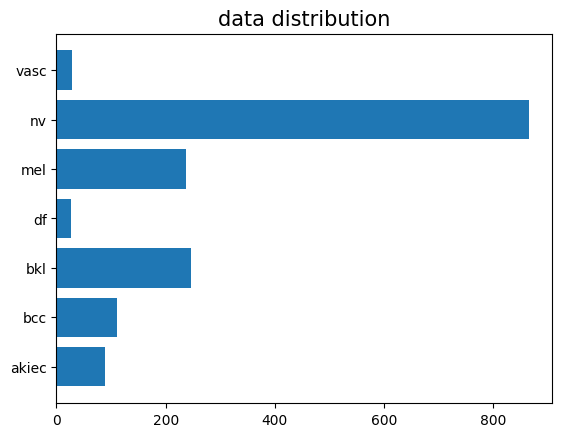

In [ ]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
ALmodel.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1)

Epoch 1/12
81/81 [==============================] - 4s 49ms/step - loss: 0.6587 - accuracy: 0.8110
Epoch 2/12
81/81 [==============================] - 2s 26ms/step - loss: 0.2759 - accuracy: 0.9058
Epoch 3/12
81/81 [==============================] - 2s 26ms/step - loss: 0.1449 - accuracy: 0.9495
Epoch 4/12
81/81 [==============================] - 2s 28ms/step - loss: 0.0880 - accuracy: 0.9744
Epoch 5/12
81/81 [==============================] - 2s 27ms/step - loss: 0.0873 - accuracy: 0.9688
Epoch 6/12
81/81 [==============================] - 2s 26ms/step - loss: 0.0578 - accuracy: 0.9832
Epoch 7/12
81/81 [==============================] - 2s 26ms/step - loss: 0.1751 - accuracy: 0.9464
Epoch 8/12
81/81 [==============================] - 2s 26ms/step - loss: 0.1011 - accuracy: 0.9669
Epoch 9/12
81/81 [==============================] - 2s 27ms/step - loss: 0.0903 - accuracy: 0.9701
Epoch 10/12
81/81 [==============================] - 2s 27ms/step - loss: 0.0629 - accuracy: 0.9769
Epoch 11/

In [ ]:
# TESTING
predAL = ALmodel.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.44      0.35      0.39        65
           1       0.35      0.63      0.45       103
           2       0.52      0.27      0.36       220
           3       0.75      0.13      0.22        23
           4       0.51      0.35      0.41       223
           5       0.86      0.92      0.89      1341
           6       0.62      0.54      0.58        28

   micro avg       0.75      0.73      0.74      2003
   macro avg       0.58      0.46      0.47      2003
weighted avg       0.74      0.73      0.73      2003
 samples avg       0.73      0.73      0.73      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 25% 

## PREDICT ON UNLABELED DATA SET WITH PREVIOUS TRAINED MODEL COMPUTES NEXT DISTRIBUTION ON U AND GET BATCH TO BE ADD

predAL = ALmodel.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


201/201 [==============================] - 4s 21ms/step


In [ ]:
# GETTING AND ADDING NEXT BATCH

batch = get_active_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 25% 404


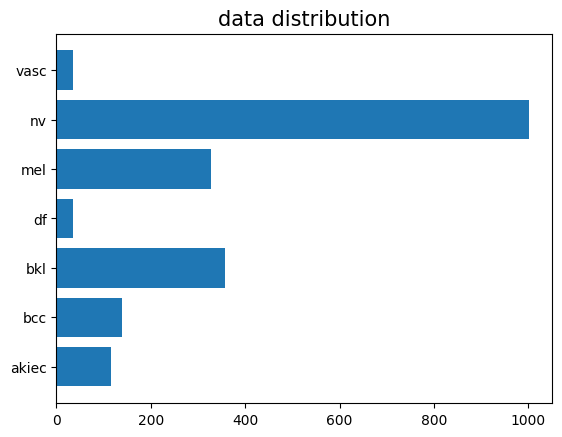

In [ ]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
ALmodel.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1)

Epoch 1/12
101/101 [==============================] - 5s 45ms/step - loss: 0.4507 - accuracy: 0.8610
Epoch 2/12
101/101 [==============================] - 3s 27ms/step - loss: 0.1862 - accuracy: 0.9367
Epoch 3/12
101/101 [==============================] - 3s 27ms/step - loss: 0.1140 - accuracy: 0.9626
Epoch 4/12
101/101 [==============================] - 3s 26ms/step - loss: 0.0926 - accuracy: 0.9706
Epoch 5/12
101/101 [==============================] - 3s 26ms/step - loss: 0.0574 - accuracy: 0.9811
Epoch 6/12
101/101 [==============================] - 3s 26ms/step - loss: 0.0696 - accuracy: 0.9736
Epoch 7/12
101/101 [==============================] - 3s 27ms/step - loss: 0.0847 - accuracy: 0.9706
Epoch 8/12
101/101 [==============================] - 3s 27ms/step - loss: 0.0530 - accuracy: 0.9831
Epoch 9/12
101/101 [==============================] - 3s 26ms/step - loss: 0.0631 - accuracy: 0.9746
Epoch 10/12
101/101 [==============================] - 3s 27ms/step - loss: 0.0604 - accura

In [ ]:
# TESTING
predAL = ALmodel.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.38      0.23      0.29        65
           1       0.54      0.39      0.45       103
           2       0.44      0.63      0.52       220
           3       0.43      0.13      0.20        23
           4       0.43      0.27      0.33       223
           5       0.86      0.89      0.88      1341
           6       0.80      0.57      0.67        28

   micro avg       0.74      0.73      0.74      2003
   macro avg       0.55      0.44      0.48      2003
weighted avg       0.73      0.73      0.73      2003
 samples avg       0.73      0.73      0.73      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 30% 

## PREDICT ON UNLABELED DATA SET WITH PREVIOUS TRAINED MODEL COMPUTES NEXT DISTRIBUTION ON U AND GET BATCH TO BE ADD

predAL = ALmodel.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


188/188 [==============================] - 4s 21ms/step


In [ ]:
# GETTING AND ADDING NEXT BATCH

batch = get_active_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 30% 405


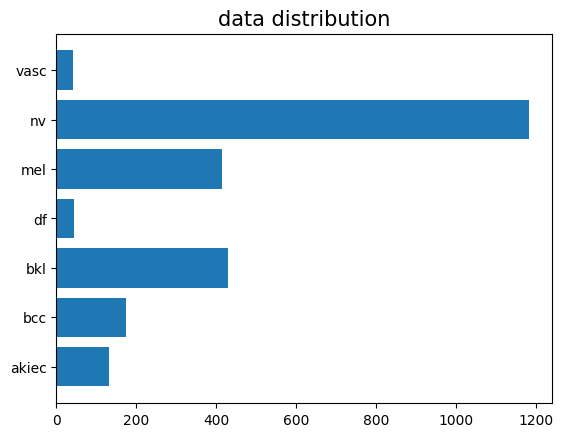

In [ ]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
ALmodel.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1)

Epoch 1/12
121/121 [==============================] - 5s 43ms/step - loss: 0.3932 - accuracy: 0.8926
Epoch 2/12
121/121 [==============================] - 3s 26ms/step - loss: 0.1615 - accuracy: 0.9540
Epoch 3/12
121/121 [==============================] - 3s 27ms/step - loss: 0.0772 - accuracy: 0.9718
Epoch 4/12
121/121 [==============================] - 3s 27ms/step - loss: 0.0731 - accuracy: 0.9743
Epoch 5/12
121/121 [==============================] - 3s 27ms/step - loss: 0.0966 - accuracy: 0.9701
Epoch 6/12
121/121 [==============================] - 3s 26ms/step - loss: 0.0698 - accuracy: 0.9780
Epoch 7/12
121/121 [==============================] - 3s 26ms/step - loss: 0.0473 - accuracy: 0.9842
Epoch 8/12
121/121 [==============================] - 3s 26ms/step - loss: 0.0316 - accuracy: 0.9888
Epoch 9/12
121/121 [==============================] - 3s 27ms/step - loss: 0.0730 - accuracy: 0.9760
Epoch 10/12
121/121 [==============================] - 3s 26ms/step - loss: 0.0413 - accura

In [ ]:
# TESTING
predAL = ALmodel.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.67      0.09      0.16        65
           1       0.48      0.47      0.47       103
           2       0.44      0.51      0.47       220
           3       0.67      0.09      0.15        23
           4       0.52      0.33      0.40       223
           5       0.86      0.93      0.89      1341
           6       0.67      0.64      0.65        28

   micro avg       0.76      0.75      0.75      2003
   macro avg       0.61      0.44      0.46      2003
weighted avg       0.74      0.75      0.73      2003
 samples avg       0.75      0.75      0.75      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 35% 

## PREDICT ON UNLABELED DATA SET WITH PREVIOUS TRAINED MODEL COMPUTES NEXT DISTRIBUTION ON U AND GET BATCH TO BE ADD

predAL = ALmodel.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


175/175 [==============================] - 4s 20ms/step


In [ ]:
# GETTING AND ADDING NEXT BATCH

batch = get_active_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 35% 402


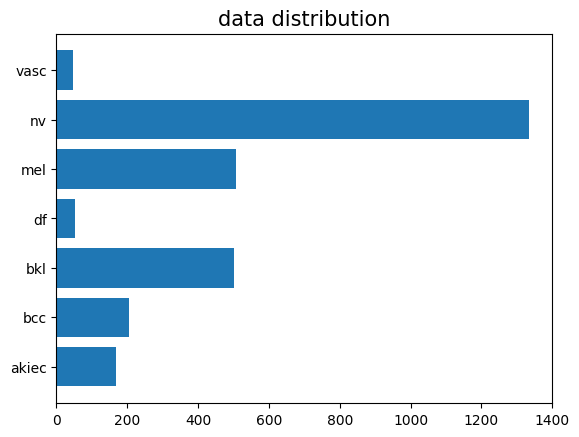

In [ ]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
ALmodel.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1)

Epoch 1/12
141/141 [==============================] - 6s 41ms/step - loss: 0.3660 - accuracy: 0.9005
Epoch 2/12
141/141 [==============================] - 4s 26ms/step - loss: 0.1742 - accuracy: 0.9467
Epoch 3/12
141/141 [==============================] - 4s 27ms/step - loss: 0.0962 - accuracy: 0.9670
Epoch 4/12
141/141 [==============================] - 4s 27ms/step - loss: 0.0488 - accuracy: 0.9840
Epoch 5/12
141/141 [==============================] - 4s 27ms/step - loss: 0.0429 - accuracy: 0.9837
Epoch 6/12
141/141 [==============================] - 4s 26ms/step - loss: 0.0870 - accuracy: 0.9719
Epoch 7/12
141/141 [==============================] - 4s 27ms/step - loss: 0.0582 - accuracy: 0.9797
Epoch 8/12
141/141 [==============================] - 4s 26ms/step - loss: 0.0553 - accuracy: 0.9822
Epoch 9/12
141/141 [==============================] - 4s 26ms/step - loss: 0.0547 - accuracy: 0.9794
Epoch 10/12
141/141 [==============================] - 4s 27ms/step - loss: 0.0496 - accura

In [ ]:
# TESTING
predAL = ALmodel.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.41      0.40      0.40        65
           1       0.61      0.66      0.64       103
           2       0.59      0.53      0.56       220
           3       0.50      0.26      0.34        23
           4       0.54      0.32      0.40       223
           5       0.86      0.93      0.90      1341
           6       0.86      0.68      0.76        28

   micro avg       0.78      0.78      0.78      2003
   macro avg       0.63      0.54      0.57      2003
weighted avg       0.77      0.78      0.77      2003
 samples avg       0.78      0.78      0.78      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 40% 

## PREDICT ON UNLABELED DATA SET WITH PREVIOUS TRAINED MODEL COMPUTES NEXT DISTRIBUTION ON U AND GET BATCH TO BE ADD

predAL = ALmodel.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


163/163 [==============================] - 3s 20ms/step


In [ ]:
# GETTING AND ADDING NEXT BATCH

batch = get_active_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 40% 404


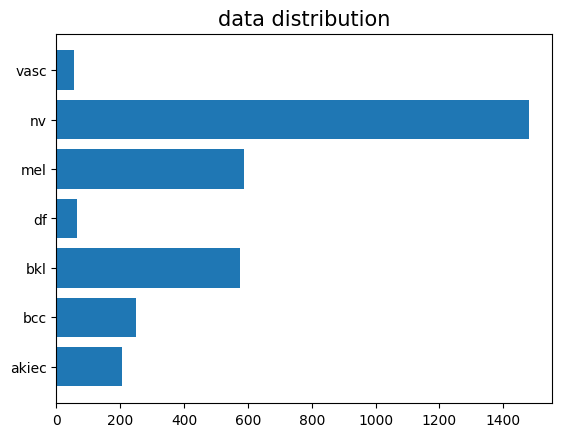

In [ ]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

#####

In [ ]:
ALmodel.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1)

Epoch 1/12
161/161 [==============================] - 6s 38ms/step - loss: 0.3221 - accuracy: 0.9124
Epoch 2/12
161/161 [==============================] - 4s 27ms/step - loss: 0.1508 - accuracy: 0.9556
Epoch 3/12
161/161 [==============================] - 4s 26ms/step - loss: 0.0861 - accuracy: 0.9720
Epoch 4/12
161/161 [==============================] - 4s 27ms/step - loss: 0.0762 - accuracy: 0.9714
Epoch 5/12
161/161 [==============================] - 4s 27ms/step - loss: 0.0692 - accuracy: 0.9782
Epoch 6/12
161/161 [==============================] - 4s 26ms/step - loss: 0.0507 - accuracy: 0.9820
Epoch 7/12
161/161 [==============================] - 4s 27ms/step - loss: 0.0581 - accuracy: 0.9798
Epoch 8/12
161/161 [==============================] - 4s 27ms/step - loss: 0.0438 - accuracy: 0.9851
Epoch 9/12
161/161 [==============================] - 4s 26ms/step - loss: 0.0486 - accuracy: 0.9826
Epoch 10/12
161/161 [==============================] - 4s 27ms/step - loss: 0.0464 - accura

In [ ]:
# TESTING
predAL = ALmodel.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.62      0.12      0.21        65
           1       0.50      0.59      0.54       103
           2       0.48      0.69      0.56       220
           3       0.44      0.35      0.39        23
           4       0.57      0.31      0.40       223
           5       0.88      0.91      0.89      1341
           6       0.93      0.50      0.65        28

   micro avg       0.77      0.76      0.77      2003
   macro avg       0.63      0.50      0.52      2003
weighted avg       0.77      0.76      0.75      2003
 samples avg       0.76      0.76      0.76      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 50% 

## PREDICT ON UNLABELED DATA SET WITH PREVIOUS TRAINED MODEL COMPUTES NEXT DISTRIBUTION ON U AND GET BATCH TO BE ADD

predAL = ALmodel.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


150/150 [==============================] - 3s 20ms/step


In [ ]:
# GETTING AND ADDING NEXT BATCH

batch = get_active_batch(10)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("ACTIVE SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

ACTIVE SAMPLED NOW TRAINING SET AT 51% 862


In [ ]:
ALmodel.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1)

Epoch 1/12
204/204 [==============================] - 5s 27ms/step - loss: 0.3352 - accuracy: 0.9069
Epoch 2/12
204/204 [==============================] - 5s 27ms/step - loss: 0.1503 - accuracy: 0.9534
Epoch 3/12
204/204 [==============================] - 6s 27ms/step - loss: 0.0907 - accuracy: 0.9706
Epoch 4/12
204/204 [==============================] - 5s 26ms/step - loss: 0.0816 - accuracy: 0.9745
Epoch 5/12
204/204 [==============================] - 5s 26ms/step - loss: 0.0741 - accuracy: 0.9750
Epoch 6/12
204/204 [==============================] - 6s 27ms/step - loss: 0.0520 - accuracy: 0.9855
Epoch 7/12
204/204 [==============================] - 5s 27ms/step - loss: 0.0399 - accuracy: 0.9882
Epoch 8/12
204/204 [==============================] - 5s 27ms/step - loss: 0.0368 - accuracy: 0.9863
Epoch 9/12
204/204 [==============================] - 5s 27ms/step - loss: 0.0406 - accuracy: 0.9860
Epoch 10/12
204/204 [==============================] - 6s 27ms/step - loss: 0.0405 - accura

In [ ]:
# TESTING
predAL = ALmodel.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.45      0.40      0.42        65
           1       0.53      0.50      0.51       103
           2       0.58      0.50      0.53       220
           3       0.50      0.39      0.44        23
           4       0.53      0.45      0.49       223
           5       0.88      0.92      0.90      1341
           6       0.60      0.75      0.67        28

   micro avg       0.78      0.78      0.78      2003
   macro avg       0.58      0.56      0.57      2003
weighted avg       0.77      0.78      0.77      2003
 samples avg       0.78      0.78      0.78      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


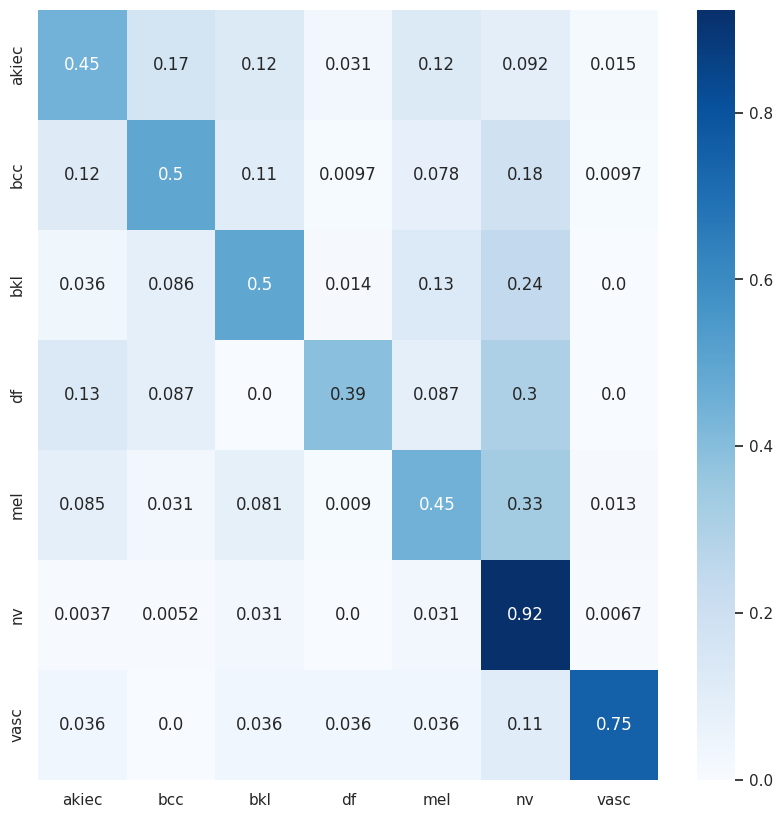

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames)

In [ ]:
# 60% 

## PREDICT ON UNLABELED DATA SET WITH PREVIOUS TRAINED MODEL COMPUTES NEXT DISTRIBUTION ON U AND GET BATCH TO BE ADD

predAL = ALmodel.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


123/123 [==============================] - 3s 21ms/step


In [ ]:
# GETTING AND ADDING NEXT BATCH

batch = get_active_batch(10)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 100% 3932


In [ ]:
ALmodel.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1)

Epoch 1/12
401/401 [==============================] - 11s 27ms/step - loss: 0.2438 - accuracy: 0.9435
Epoch 2/12
401/401 [==============================] - 11s 27ms/step - loss: 0.1267 - accuracy: 0.9653
Epoch 3/12
401/401 [==============================] - 11s 27ms/step - loss: 0.0826 - accuracy: 0.9740
Epoch 4/12
401/401 [==============================] - 11s 27ms/step - loss: 0.0711 - accuracy: 0.9783
Epoch 5/12
401/401 [==============================] - 11s 26ms/step - loss: 0.0614 - accuracy: 0.9799
Epoch 6/12
401/401 [==============================] - 11s 27ms/step - loss: 0.0725 - accuracy: 0.9752
Epoch 7/12
401/401 [==============================] - 11s 27ms/step - loss: 0.0459 - accuracy: 0.9834
Epoch 8/12
401/401 [==============================] - 11s 27ms/step - loss: 0.0492 - accuracy: 0.9835
Epoch 9/12
401/401 [==============================] - 11s 27ms/step - loss: 0.0494 - accuracy: 0.9830
Epoch 10/12
401/401 [==============================] - 11s 27ms/step - loss: 0.048

In [ ]:
# TESTING
predAL = ALmodel.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))


63/63 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.48      0.32      0.39        65
           1       0.53      0.69      0.60       103
           2       0.62      0.48      0.54       220
           3       0.47      0.35      0.40        23
           4       0.56      0.43      0.49       223
           5       0.88      0.92      0.90      1341
           6       0.60      0.86      0.71        28

   micro avg       0.79      0.78      0.78      2003
   macro avg       0.59      0.58      0.57      2003
weighted avg       0.77      0.78      0.77      2003
 samples avg       0.78      0.78      0.78      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


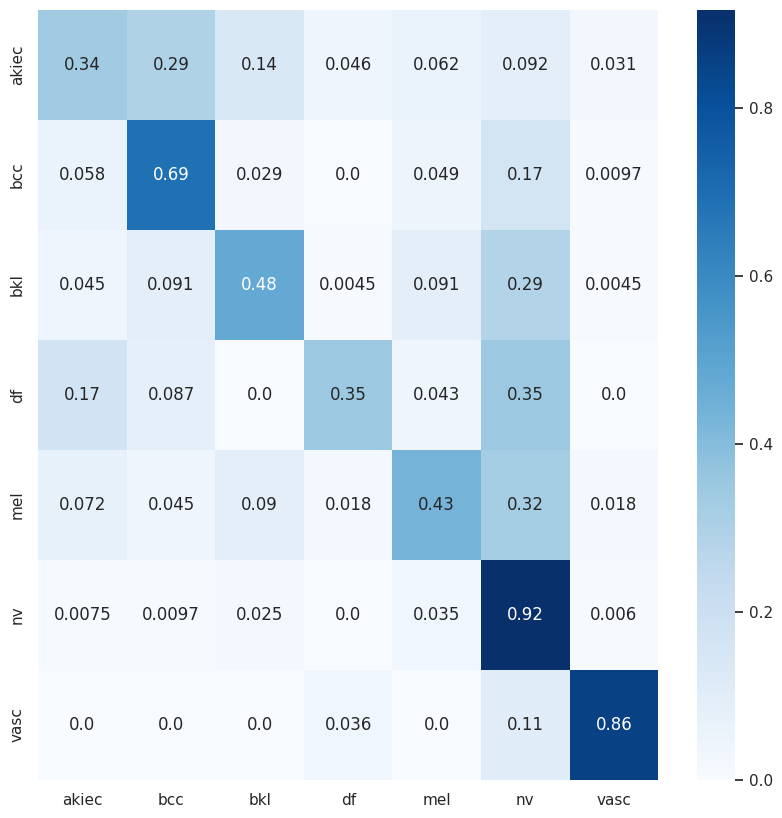

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames) 

<a id='diversity'></a>
### DIVERSITY SAMPLING

#### Diversity with (uncertainty) Strategy

* prioritizing Diversity while progressing on Uncertainty least confidence strategy

# content
   1. [Import Library and mount google drive](#importing_libraries)
   2. [Load HAM10K data set to memory](#loading_dataset)
   3. [Describe general Active learn Process Flow](#process_flow)
   4. [description of core feature DIVERSITY(uncertainty) Strategy](#Diversity)
   5. [8*RUNS of experiment for statistical confidence](#runs)
       * reset train/test split 
       * starting from 10% 
       * Visualize how strategy is sampling through imbalanced dataset
       * test on testset at every step and document result

       

<a id='importing_libraries'></a>
### IMPORTING SOME LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib 
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import time

from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,ZeroPadding2D,Input #importing some cool keras layers 1st
import random

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:

os.chdir('gdrive/MyDrive/3PROJECT')
#os.listdir()
#os.getcwd()

<a id='loading_dataset'></a>
### HAM10000 DATASET LOAD

APPROACH A: load data in from both folders in to a REPO in script memory

then while loading each file; match file name with csv and load Target to a TAR file also in memory

In [ ]:

# reading target source file into dataframe
skin_df = pd.read_csv('HAM10000/HAM10000_metadata.csv')

In [ ]:
# this data is stored in a local directory "HAM10000"
# using os to locate files and cv2 to read into Numpy arrays
resize_width = 128
resize_height = 128
path = "HAM10000"
IMAGE = [] # List to append the images as 2D numpy arrays.
TARGET = [] # List to append the target all ch


for root, dirs, files in os.walk(path):
     for file in files:
         if '(1)' not in file:
             with open(os.path.join(root, file), "r") as auto:
                 try:
              
                     img = cv2.imread(root+'/'+file)   # cv2 reads image to a 2d ie grayscale=0 full_RGB = _default_blank_
                     img = cv2.resize(img, (resize_width, resize_height)) # image resize to 128/128
                     IMAGE.append(img)
                     # Append the folder where the image is to the target list
                     TARGET.append(list(skin_df.dx[skin_df.image_id == file.replace('.jpg','')])[0])
                 except Exception as e:
                     print("Invalid file "+file+" skipped.")

for part in np.unique(TARGET):
    print ('{} has {} images'.format(part,TARGET.count(part)))
print("TOTAL IMAGES =",len(TARGET))

Invalid file HAM10000_metadata.csv skipped.
Invalid file hmnist_28_28_L.csv skipped.
Invalid file hmnist_8_8_L.csv skipped.
Invalid file hmnist_8_8_RGB.csv skipped.
Invalid file hmnist_28_28_RGB.csv skipped.
akiec has 327 images
bcc has 514 images
bkl has 1099 images
df has 115 images
mel has 1113 images
nv has 6705 images
vasc has 142 images
TOTAL IMAGES = 10015


In [ ]:
IMAGE[0].shape

(128, 128, 3)

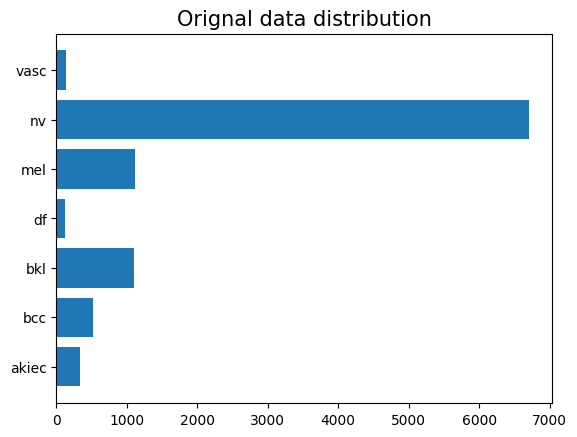

In [ ]:
## showing distribution
parts = np.unique(TARGET)
count=[]
for part in parts:
    count.append(TARGET.count(part))
plt.barh(parts,count)
plt.title("Orignal data distribution",size = 15)
plt.show()

Text(0.5, 0, 'nv             nv               nv  ')

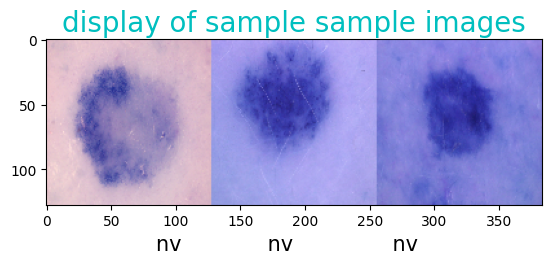

In [ ]:
im_sample=np.concatenate((IMAGE[0],IMAGE[5010],IMAGE[10000]),axis=1)
plt.imshow(im_sample)
plt.title("display of sample sample images",size=20,color="c")
plt.xlabel("{}             {}               {}  ".format(TARGET[0],TARGET[5010],TARGET[10000]),size=15)

In [ ]:
## RENAMING TARGET LABELS so TARGET CAN WORK WITH A CLASSIFIER ALOGRITHM
def re_label(targets):
    TAR=[]
    for part in targets:
        if part == 'akiec':
            TAR.append(0)
        elif part == 'bcc':
            TAR.append(1)
        elif part == 'bkl':
            TAR.append(2)
        elif part == 'df':
            TAR.append(3)
        elif part == 'mel':
            TAR.append(4)
        elif part == 'nv':
            TAR.append(5)
        else:
            TAR.append(6)
    return (TAR)
TARo = re_label(TARGET)

## reverse np labels
def revs_label(np_targets):
    Target=[]
    for part in np_targets:
        if part[0] == 1:
            Target.append('akiec')
        elif part[1] == 1:
            Target.append('bcc')
        elif part[2] == 1:
            Target.append('bkl')
        elif part[3] == 1:
            Target.append('df')
        elif part[4] == 1:
            Target.append('mel')
        elif part[5] == 1:
            Target.append('nv')
        elif part[6] == 1:
            Target.append('vasc')
    return (Target)

In [ ]:
# CONFUSION MATRIX FUNCTION
def plot_confusion_matrix(y_test,y_scores, classNames):
    y_test=np.argmax(y_test, axis=1)
    y_scores=np.argmax(y_scores, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]/np.sum(cm[x,:])

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1) # for label size
    df = sns.heatmap(con, annot=True,fmt='.2', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
classNames = ['akiec','bcc','bkl','df','mel','nv','vasc'] 
# source https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels

<a id='process_flow'></a>
### ACTIVE LEARNING (AL) PROCESS FLOW 
**Require :**
1. initial labeled set for training ***IMAGES_L, TARGET_L***
2. Unlabeled for test ***IMAGES_U***
3. based on initial trained model ***ModelAL*** certain batch to be auto-label and absorbed
4. informative batch to be query ***x_batch*** and get ***y*** from ORACLE ***O_Target*** 
5. add ***x_batch*** to Labeled training set ***L*** (IMAGES and TARGET)
6. remove ***x_batch*** from Unlabeled ***IMAGES_U***
7. retraining model ***ModelAL***
8. testing model ***ModelAL***  on test set
9. reach final model ***M***


![diversity](CODE/hiddenactivation.png)

#### as shown by (Monarch and Manning 2021 pp. 89–93)

![caption](CODE/hiddenactivation2.PNG)

![softmax](CODE/softmax.png)

![error training](CODE/error.jpg)

#### SOFTSIGN: activation function 

In [10]:
### SOFT SIGN ACTIVATION
help(tf.keras.activations.softsign)

Help on function softsign in module keras.activations:

softsign(x)
    Softsign activation function, `softsign(x) = x / (abs(x) + 1)`.
    
    Example Usage:
    
    >>> a = tf.constant([-1.0, 0.0, 1.0], dtype = tf.float32)
    >>> b = tf.keras.activations.softsign(a)
    >>> b.numpy()
    array([-0.5,  0. ,  0.5], dtype=float32)
    
    Args:
        x: Input tensor.
    
    Returns:
        The softsign activation: `x / (abs(x) + 1)`.



#### S_SOFT: defining activation function that enables me deduct class polarity of instance predictions 

In [ ]:
def s_soft(x):
    return((tf.keras.activations.softsign(x)+1)/2)

#### Difference between softmax and s_soft from keras.activations.softsign

* "softmax" creates a probability representation from 0 to 1 on predicted instance while "softsign" show similar probability but allowing -ve activation to maintain sign, because Keras model required for a training model the activation to be +ve and between 0 to 1; create the activation from s_soft for softsign that i can scale back to allow me see those instances that orginally had -ve activation

***S_SOFT IDEA***

1. with the s_soft activation:to serve as output activation instead of "SOFTMAX"
2. from our prediction on the unlabeled class, see can easily see and deduce that any value below 0.5 was -ve
2. a -ve score from a NN may mean that, the Network hasn't got a lot of information in that feature space
3. in theory, such instances have most information 
4. the plan is to exhaust this diverse instances then proceed to fetching blanket uncertainty





### Diversity Function

In [ ]:
# DIVERSITY FUNCTION

# USING THE FACT THAT CLASSES BELOW 0.5 ARE EQUVALENT TO -VE LOGITS FROM THE Tanh RESULT THE FUNCTION HERE PRIORITIZE INSTANCE WITH -VE LOGIST FIRST
# AND WHEN SUCH SAMPLES IS EXHUSTED THE FUNCTION RESULT BACK TO LEAST CONFIDENCE
def get_diverse_batch(percent): 
    Per = len(TAR)*percent/100
    uncertainty = 0.5
    batch=[]
    
    while (len(batch) < Per)&(len(predAL)>Per):
        batch=[]
        margin = 0.9
        if uncertainty <= 0.5:
            while (margin > 0.05):
                batch=[]
                for i in range (len(predAL)):
                    y = list(predAL[i])
                    y.sort(reverse = True)
                    if (y[0] < uncertainty) & ((y[0]-y[1])>margin): 
                        batch.append(i)
                    if len(batch) >= Per:
                        break
                margin = margin*4/5

            if (len(batch) < Per):
                uncertainty+= 0.001
                
        else:   
            for i in range (len(predAL)):
                y = max(list(predAL[i]))
                if y < uncertainty: 
                    batch.append(i)
            uncertainty+= 0.001
    return (batch)

In [ ]:
modelAL = Sequential()

pretrained_model= tf.keras.applications.DenseNet201(
    include_top=False,
    input_shape=(128,128,3),
    pooling='avg',
    classes=1000,
    weights='imagenet',
)                     # 

for each_layer in pretrained_model.layers[:-25]:  # 20 BOTH 78%

        each_layer.trainable=False                             # runs a for loop to change setting on layers in model not to retrain

modelAL.add(pretrained_model)


modelAL.add(Flatten())

modelAL.add(Dense(512, activation='relu'))

modelAL.add(Dense(7, activation=s_soft))

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
modelAL.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Precision','Recall'])

<a id='runs'></a>
### DIVERSITY STRATEGY  RUN

In [ ]:
# CREATING MAIN TEST SET 10% DATASET
# also setting  seed (for reproducibility)
np.random.seed(101)

IMAGES,IMAGES_Test,TAR_Train,TARGET_Test_M = train_test_split(IMAGE,TARo,stratify=TARo,test_size=0.2)



# reshaping data for Neural Network
IMAGES = np.array(IMAGES,dtype='float64').reshape(len(IMAGES), 128, 128, 3)

IMAGES_Test = np.array(IMAGES_Test,dtype='float64').reshape(len(IMAGES_Test), 128, 128, 3)

# changing labels to array like categorical labels vital for CNN training
TAR = np_utils.to_categorical(TAR_Train, 7)
TAR_Test = np_utils.to_categorical(TARGET_Test_M, 7)  # creating categorical output for test data


# normalising
IMAGES_Test /= 255
IMAGES /= 255

##### AL Starting with a Random 10% Sample 

In [ ]:
np.random.seed(101)
r = 0.1  # 10% START TRAINING SET
IMAGES_L,IMAGES_U,TARGET_L,TARGET_O = train_test_split(IMAGES,TAR,stratify=TAR,test_size=(1-r))

print("RANDOM SAMPLED START TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

# IMAGES_L: initial labeled set for training L
# IMAGES_U: Unlabeled for pool U
# TARGET_L: corresponding target for L
# TARGET_O: ORACLE for Unlabeled pool U

RANDOM SAMPLED START TRAINING SET AT 10%


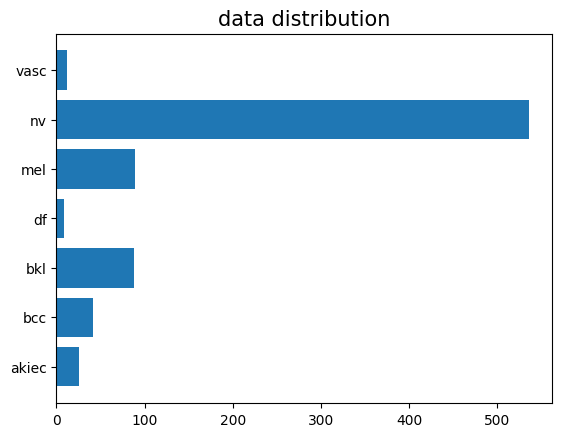

In [ ]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
41/41 [==============================] - 30s 77ms/step - loss: 1.1065 - accuracy: 0.6529 - precision: 0.5115 - recall: 0.7466
Epoch 2/12
41/41 [==============================] - 2s 42ms/step - loss: 0.8863 - accuracy: 0.6692 - precision: 0.5206 - recall: 0.8527
Epoch 3/12
41/41 [==============================] - 2s 42ms/step - loss: 0.8002 - accuracy: 0.6692 - precision: 0.5319 - recall: 0.8939
Epoch 4/12
41/41 [==============================] - 2s 43ms/step - loss: 0.7120 - accuracy: 0.6692 - precision: 0.5744 - recall: 0.9064
Epoch 5/12
41/41 [==============================] - 2s 42ms/step - loss: 0.6703 - accuracy: 0.6729 - precision: 0.5896 - recall: 0.9164
Epoch 6/12
41/41 [==============================] - 2s 43ms/step - loss: 0.6069 - accuracy: 0.6692 - precision: 0.6238 - recall: 0.9213
Epoch 7/12
41/41 [==============================] - 2s 43ms/step - loss: 0.5577 - accuracy: 0.6829 - precision: 0.6472 - recall: 0.9388
Epoch 8/12
41/41 [=============================

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')


print(classification_report(TAR_Test, pred_test))

63/63 [==============================] - 11s 82ms/step
              precision    recall  f1-score   support

           0       0.26      0.17      0.20        65
           1       0.41      0.38      0.40       103
           2       0.43      0.55      0.48       220
           3       0.00      0.00      0.00        23
           4       0.41      0.44      0.42       223
           5       0.88      0.87      0.87      1341
           6       0.67      0.50      0.57        28

   micro avg       0.72      0.72      0.72      2003
   macro avg       0.44      0.42      0.42      2003
weighted avg       0.72      0.72      0.72      2003
 samples avg       0.72      0.72      0.72      2003



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)


226/226 [==============================] - 13s 57ms/step


In [ ]:
# 15% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))


RANDOM SAMPLED NOW TRAINING SET AT 15% 402


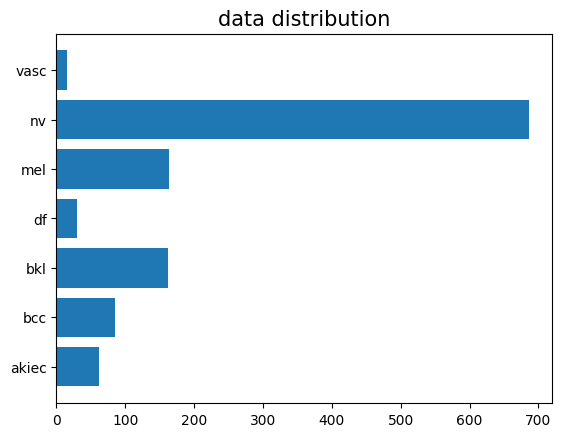

In [ ]:

## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
61/61 [==============================] - 4s 70ms/step - loss: 0.7423 - accuracy: 0.7648 - precision: 0.7832 - recall: 0.7207
Epoch 2/12
61/61 [==============================] - 3s 42ms/step - loss: 0.5976 - accuracy: 0.8163 - precision: 0.8586 - recall: 0.7473
Epoch 3/12
61/61 [==============================] - 3s 41ms/step - loss: 0.6040 - accuracy: 0.7930 - precision: 0.7556 - recall: 0.8171
Epoch 4/12
61/61 [==============================] - 3s 44ms/step - loss: 0.4846 - accuracy: 0.8653 - precision: 0.8550 - recall: 0.8188
Epoch 5/12
61/61 [==============================] - 3s 43ms/step - loss: 0.3847 - accuracy: 0.8969 - precision: 0.9092 - recall: 0.8487
Epoch 6/12
61/61 [==============================] - 3s 42ms/step - loss: 0.3068 - accuracy: 0.9144 - precision: 0.9132 - recall: 0.9011
Epoch 7/12
61/61 [==============================] - 3s 42ms/step - loss: 0.3666 - accuracy: 0.8944 - precision: 0.8790 - recall: 0.8878
Epoch 8/12
61/61 [==============================

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))

63/63 [==============================] - 3s 48ms/step
              precision    recall  f1-score   support

           0       0.34      0.32      0.33        65
           1       0.44      0.47      0.45       103
           2       0.43      0.57      0.49       220
           3       0.30      0.26      0.28        23
           4       0.38      0.43      0.40       223
           5       0.90      0.84      0.87      1341
           6       0.50      0.46      0.48        28

   micro avg       0.72      0.72      0.72      2003
   macro avg       0.47      0.48      0.47      2003
weighted avg       0.74      0.72      0.72      2003
 samples avg       0.72      0.72      0.72      2003



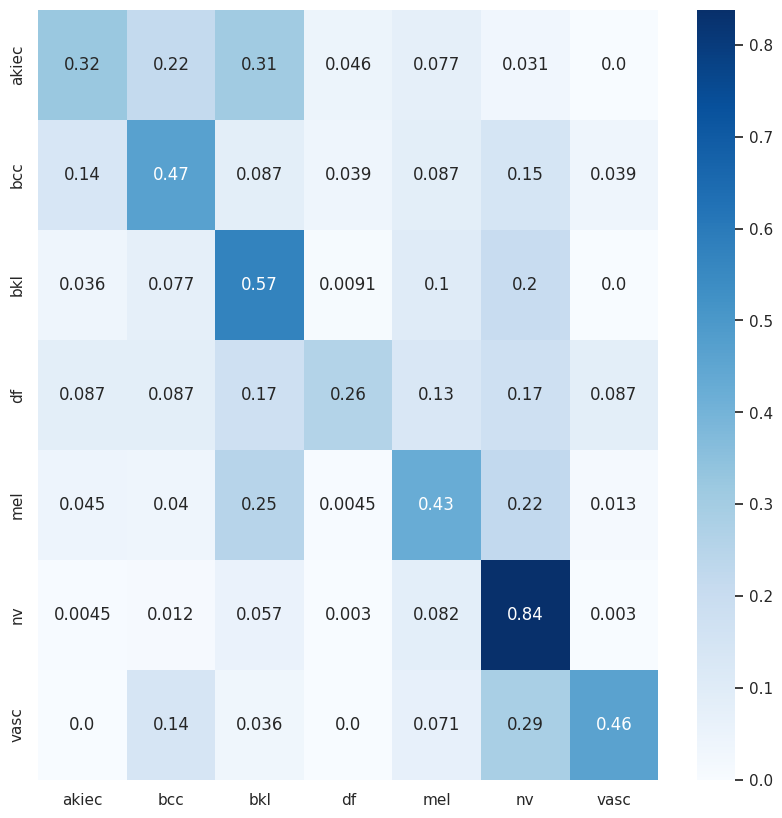

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


213/213 [==============================] - 13s 59ms/step


In [ ]:
# 20% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 20% 401


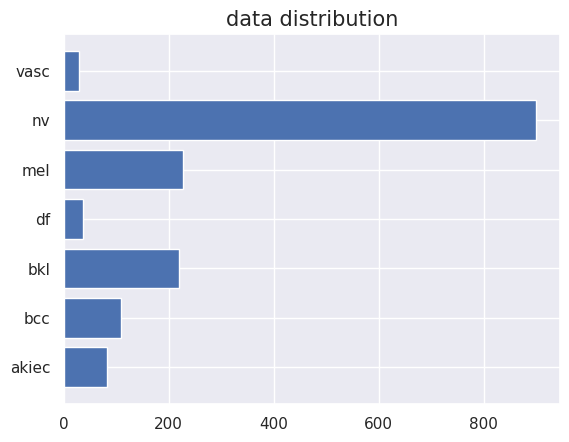

In [ ]:

## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
81/81 [==============================] - 5s 64ms/step - loss: 0.5694 - accuracy: 0.8273 - precision: 0.9115 - recall: 0.7195
Epoch 2/12
81/81 [==============================] - 4s 43ms/step - loss: 0.5387 - accuracy: 0.8460 - precision: 0.8718 - recall: 0.7843
Epoch 3/12
81/81 [==============================] - 3s 42ms/step - loss: 0.3850 - accuracy: 0.8984 - precision: 0.9214 - recall: 0.8329
Epoch 4/12
81/81 [==============================] - 3s 42ms/step - loss: 0.3249 - accuracy: 0.9096 - precision: 0.9412 - recall: 0.8678
Epoch 5/12
81/81 [==============================] - 3s 43ms/step - loss: 0.3242 - accuracy: 0.9102 - precision: 0.9047 - recall: 0.8934
Epoch 6/12
81/81 [==============================] - 4s 46ms/step - loss: 0.2966 - accuracy: 0.9177 - precision: 0.9184 - recall: 0.8984
Epoch 7/12
81/81 [==============================] - 3s 42ms/step - loss: 0.2550 - accuracy: 0.9364 - precision: 0.9360 - recall: 0.9115
Epoch 8/12
81/81 [==============================

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))

63/63 [==============================] - 3s 50ms/step
              precision    recall  f1-score   support

           0       0.38      0.23      0.29        65
           1       0.49      0.57      0.53       103
           2       0.54      0.48      0.50       220
           3       0.28      0.22      0.24        23
           4       0.50      0.30      0.38       223
           5       0.86      0.93      0.90      1341
           6       0.49      0.68      0.57        28

   micro avg       0.76      0.76      0.76      2003
   macro avg       0.51      0.49      0.49      2003
weighted avg       0.74      0.76      0.74      2003
 samples avg       0.76      0.76      0.76      2003



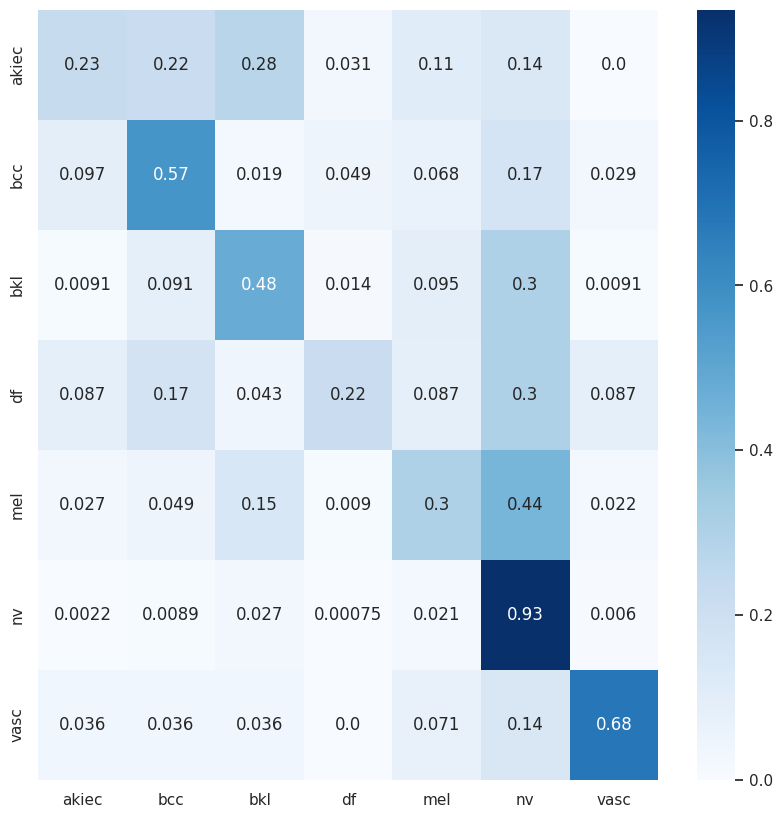

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


191/191 [==============================] - 12s 63ms/step


In [ ]:
# 25% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 29% 404


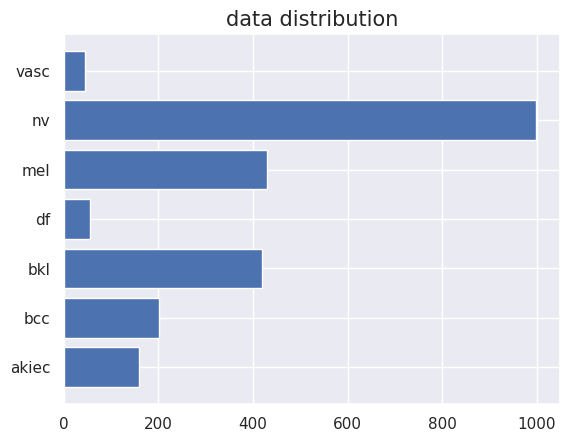

In [ ]:

## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
116/116 [==============================] - 5s 45ms/step - loss: 0.5249 - accuracy: 0.8397 - precision: 0.9207 - recall: 0.7249
Epoch 2/12
116/116 [==============================] - 5s 44ms/step - loss: 0.4120 - accuracy: 0.8769 - precision: 0.8955 - recall: 0.8432
Epoch 3/12
116/116 [==============================] - 5s 44ms/step - loss: 0.4312 - accuracy: 0.8726 - precision: 0.8974 - recall: 0.8224
Epoch 4/12
116/116 [==============================] - 5s 44ms/step - loss: 0.3380 - accuracy: 0.9034 - precision: 0.9195 - recall: 0.8614
Epoch 5/12
116/116 [==============================] - 5s 44ms/step - loss: 0.2994 - accuracy: 0.9207 - precision: 0.9348 - recall: 0.8579
Epoch 6/12
116/116 [==============================] - 5s 45ms/step - loss: 0.2078 - accuracy: 0.9476 - precision: 0.9511 - recall: 0.9190
Epoch 7/12
116/116 [==============================] - 5s 44ms/step - loss: 0.2094 - accuracy: 0.9454 - precision: 0.9553 - recall: 0.9159
Epoch 8/12
116/116 [==============

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))

63/63 [==============================] - 3s 50ms/step
              precision    recall  f1-score   support

           0       0.32      0.40      0.35        65
           1       0.51      0.59      0.55       103
           2       0.44      0.55      0.49       220
           3       0.50      0.30      0.38        23
           4       0.47      0.41      0.44       223
           5       0.89      0.86      0.87      1341
           6       0.87      0.71      0.78        28

   micro avg       0.74      0.74      0.74      2003
   macro avg       0.57      0.55      0.55      2003
weighted avg       0.75      0.74      0.74      2003
 samples avg       0.74      0.74      0.74      2003



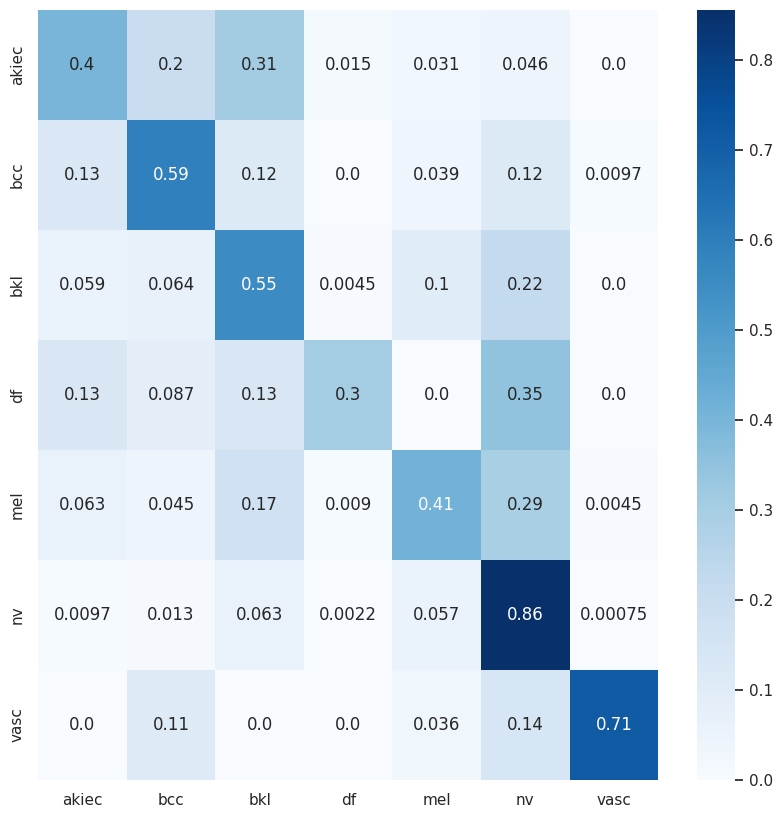

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


176/176 [==============================] - 11s 60ms/step


In [ ]:
# 30% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 35% 403


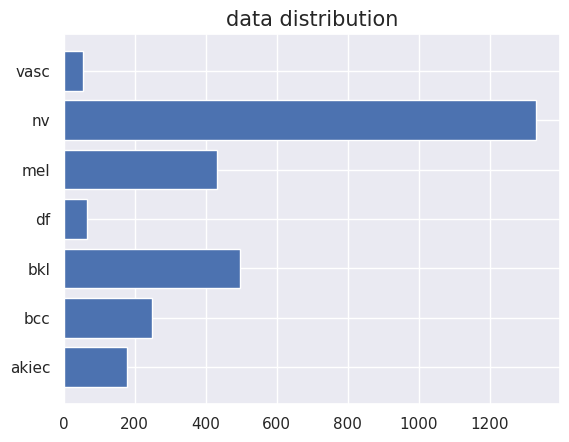

In [ ]:

## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
148/148 [==============================] - 8s 57ms/step - loss: 0.3975 - accuracy: 0.8912 - precision: 0.9229 - recall: 0.8275
Epoch 2/12
148/148 [==============================] - 6s 42ms/step - loss: 0.3339 - accuracy: 0.9054 - precision: 0.9218 - recall: 0.8753
Epoch 3/12
148/148 [==============================] - 6s 43ms/step - loss: 0.3099 - accuracy: 0.9139 - precision: 0.9504 - recall: 0.8251
Epoch 4/12
148/148 [==============================] - 6s 42ms/step - loss: 0.2680 - accuracy: 0.9268 - precision: 0.9409 - recall: 0.8905
Epoch 5/12
148/148 [==============================] - 6s 43ms/step - loss: 0.2338 - accuracy: 0.9346 - precision: 0.9454 - recall: 0.8986
Epoch 6/12
148/148 [==============================] - 6s 42ms/step - loss: 0.2128 - accuracy: 0.9454 - precision: 0.9305 - recall: 0.9302
Epoch 7/12
148/148 [==============================] - 6s 43ms/step - loss: 0.1858 - accuracy: 0.9566 - precision: 0.9584 - recall: 0.9302
Epoch 8/12
148/148 [==============

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))

63/63 [==============================] - 3s 49ms/step
              precision    recall  f1-score   support

           0       0.54      0.22      0.31        65
           1       0.48      0.51      0.50       103
           2       0.51      0.45      0.48       220
           3       0.38      0.26      0.31        23
           4       0.53      0.25      0.34       223
           5       0.83      0.95      0.88      1341
           6       0.74      0.50      0.60        28

   micro avg       0.76      0.76      0.76      2003
   macro avg       0.57      0.45      0.49      2003
weighted avg       0.73      0.76      0.73      2003
 samples avg       0.76      0.76      0.76      2003



In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


159/159 [==============================] - 10s 60ms/step


In [ ]:
# 35% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 42% 403


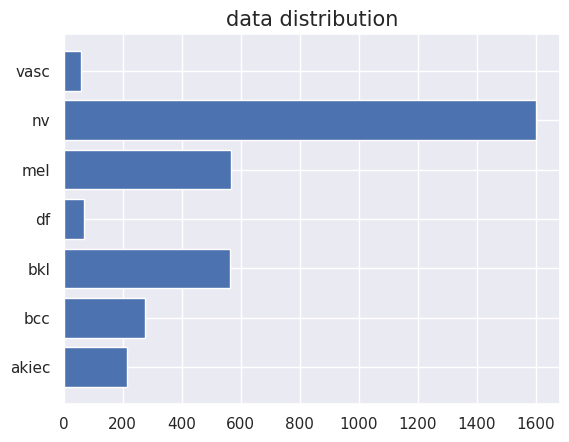

In [ ]:

## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
168/168 [==============================] - 9s 56ms/step - loss: 0.3965 - accuracy: 0.8897 - precision: 0.9212 - recall: 0.8190
Epoch 2/12
168/168 [==============================] - 7s 43ms/step - loss: 0.3326 - accuracy: 0.9016 - precision: 0.9019 - recall: 0.8834
Epoch 3/12
168/168 [==============================] - 7s 42ms/step - loss: 0.2821 - accuracy: 0.9234 - precision: 0.9165 - recall: 0.9031
Epoch 4/12
168/168 [==============================] - 7s 43ms/step - loss: 0.2560 - accuracy: 0.9266 - precision: 0.9107 - recall: 0.9216
Epoch 5/12
168/168 [==============================] - 7s 42ms/step - loss: 0.2298 - accuracy: 0.9392 - precision: 0.9252 - recall: 0.9257
Epoch 6/12
168/168 [==============================] - 7s 42ms/step - loss: 0.2168 - accuracy: 0.9415 - precision: 0.9086 - recall: 0.9401
Epoch 7/12
168/168 [==============================] - 7s 42ms/step - loss: 0.1863 - accuracy: 0.9517 - precision: 0.9321 - recall: 0.9499
Epoch 8/12
168/168 [==============

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))

63/63 [==============================] - 3s 53ms/step
              precision    recall  f1-score   support

           0       0.53      0.42      0.47        65
           1       0.55      0.60      0.57       103
           2       0.59      0.40      0.48       220
           3       0.57      0.35      0.43        23
           4       0.52      0.47      0.49       223
           5       0.86      0.93      0.89      1341
           6       0.68      0.75      0.71        28

   micro avg       0.77      0.77      0.77      2003
   macro avg       0.61      0.56      0.58      2003
weighted avg       0.76      0.77      0.76      2003
 samples avg       0.77      0.77      0.77      2003



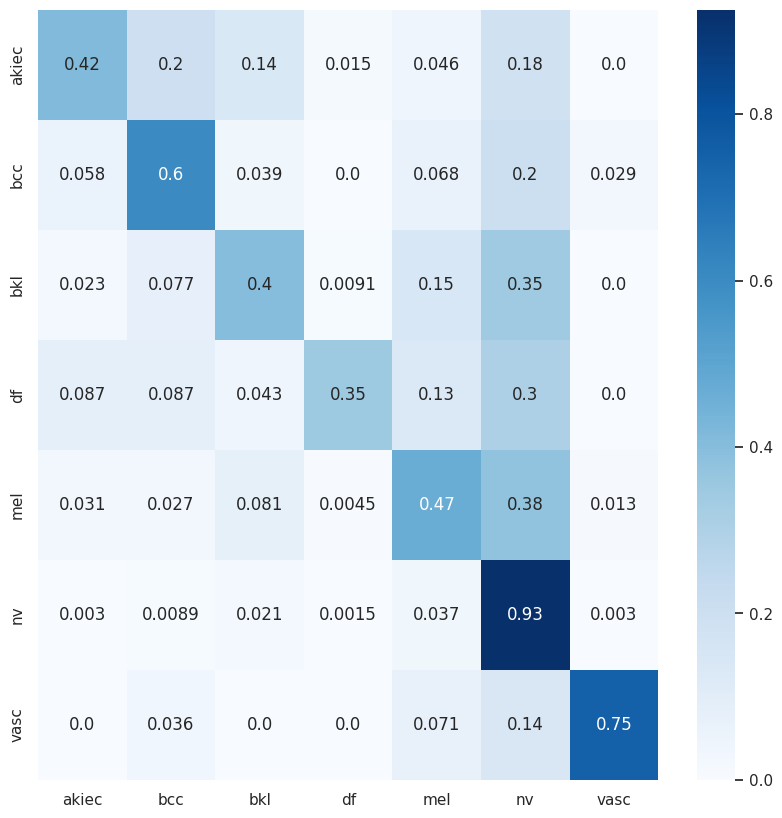

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames ) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


146/146 [==============================] - 7s 49ms/step


In [ ]:
# 40% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 47% 410


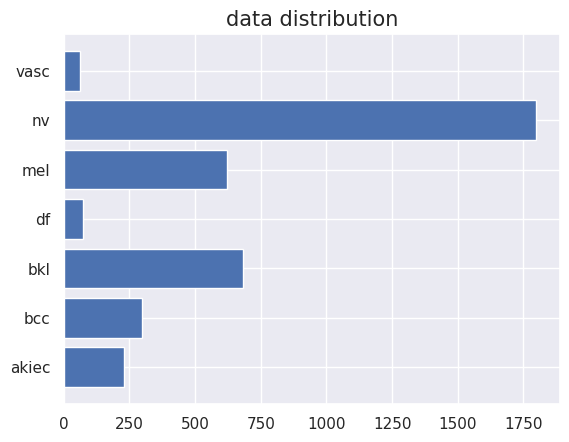

In [ ]:

## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
189/189 [==============================] - 10s 51ms/step - loss: 0.3620 - accuracy: 0.9011 - precision: 0.9004 - recall: 0.8815
Epoch 2/12
189/189 [==============================] - 8s 43ms/step - loss: 0.2981 - accuracy: 0.9134 - precision: 0.8773 - recall: 0.9197
Epoch 3/12
189/189 [==============================] - 8s 43ms/step - loss: 0.2728 - accuracy: 0.9232 - precision: 0.8966 - recall: 0.9192
Epoch 4/12
189/189 [==============================] - 8s 43ms/step - loss: 0.2230 - accuracy: 0.9381 - precision: 0.9122 - recall: 0.9413
Epoch 5/12
189/189 [==============================] - 8s 42ms/step - loss: 0.2013 - accuracy: 0.9471 - precision: 0.9376 - recall: 0.9344
Epoch 6/12
189/189 [==============================] - 8s 43ms/step - loss: 0.2046 - accuracy: 0.9410 - precision: 0.9465 - recall: 0.9118
Epoch 7/12
189/189 [==============================] - 8s 43ms/step - loss: 0.2117 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.8956
Epoch 8/12
189/189 [=============

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))

63/63 [==============================] - 3s 49ms/step
              precision    recall  f1-score   support

           0       0.55      0.37      0.44        65
           1       0.59      0.32      0.42       103
           2       0.60      0.46      0.52       220
           3       0.43      0.13      0.20        23
           4       0.63      0.38      0.47       223
           5       0.82      0.96      0.89      1341
           6       0.73      0.68      0.70        28

   micro avg       0.78      0.78      0.78      2003
   macro avg       0.62      0.47      0.52      2003
weighted avg       0.75      0.78      0.75      2003
 samples avg       0.78      0.78      0.78      2003



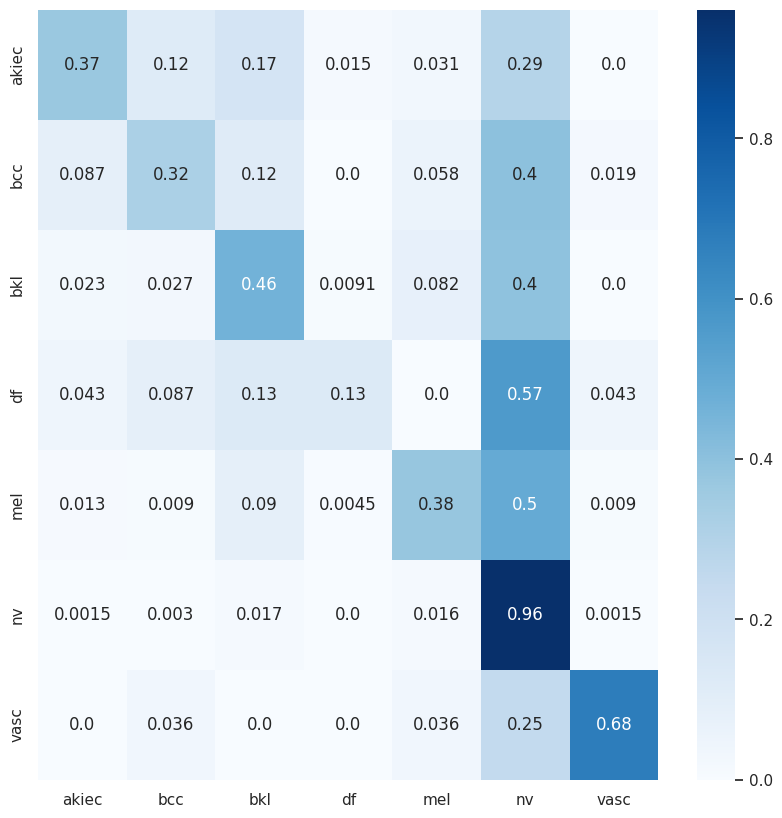

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames ) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


133/133 [==============================] - 9s 67ms/step


In [ ]:
# 45% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 52% 405


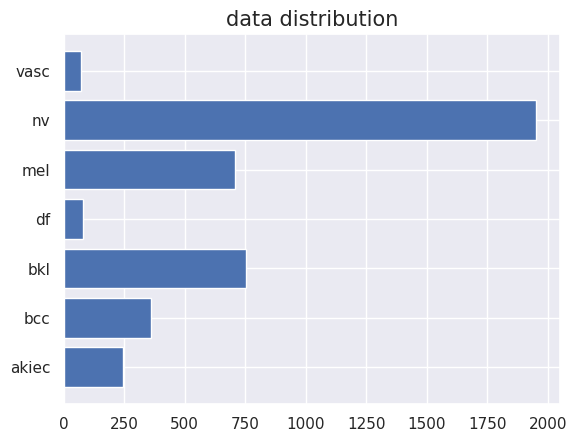

In [ ]:

## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
209/209 [==============================] - 11s 52ms/step - loss: 0.2826 - accuracy: 0.9218 - precision: 0.9005 - recall: 0.9206
Epoch 2/12
209/209 [==============================] - 9s 42ms/step - loss: 0.2604 - accuracy: 0.9283 - precision: 0.9171 - recall: 0.9052
Epoch 3/12
209/209 [==============================] - 9s 43ms/step - loss: 0.2395 - accuracy: 0.9326 - precision: 0.9138 - recall: 0.9182
Epoch 4/12
209/209 [==============================] - 9s 43ms/step - loss: 0.1966 - accuracy: 0.9424 - precision: 0.9058 - recall: 0.9554
Epoch 5/12
209/209 [==============================] - 9s 42ms/step - loss: 0.1954 - accuracy: 0.9482 - precision: 0.9111 - recall: 0.9563
Epoch 6/12
209/209 [==============================] - 9s 42ms/step - loss: 0.1693 - accuracy: 0.9547 - precision: 0.9376 - recall: 0.9487
Epoch 7/12
209/209 [==============================] - 9s 43ms/step - loss: 0.1738 - accuracy: 0.9525 - precision: 0.9300 - recall: 0.9503
Epoch 8/12
209/209 [=============

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))

63/63 [==============================] - 3s 50ms/step
              precision    recall  f1-score   support

           0       0.52      0.26      0.35        65
           1       0.57      0.66      0.61       103
           2       0.60      0.49      0.54       220
           3       0.30      0.26      0.28        23
           4       0.53      0.42      0.47       223
           5       0.86      0.93      0.89      1341
           6       0.78      0.64      0.71        28

   micro avg       0.78      0.78      0.78      2003
   macro avg       0.59      0.52      0.55      2003
weighted avg       0.76      0.78      0.77      2003
 samples avg       0.78      0.78      0.78      2003



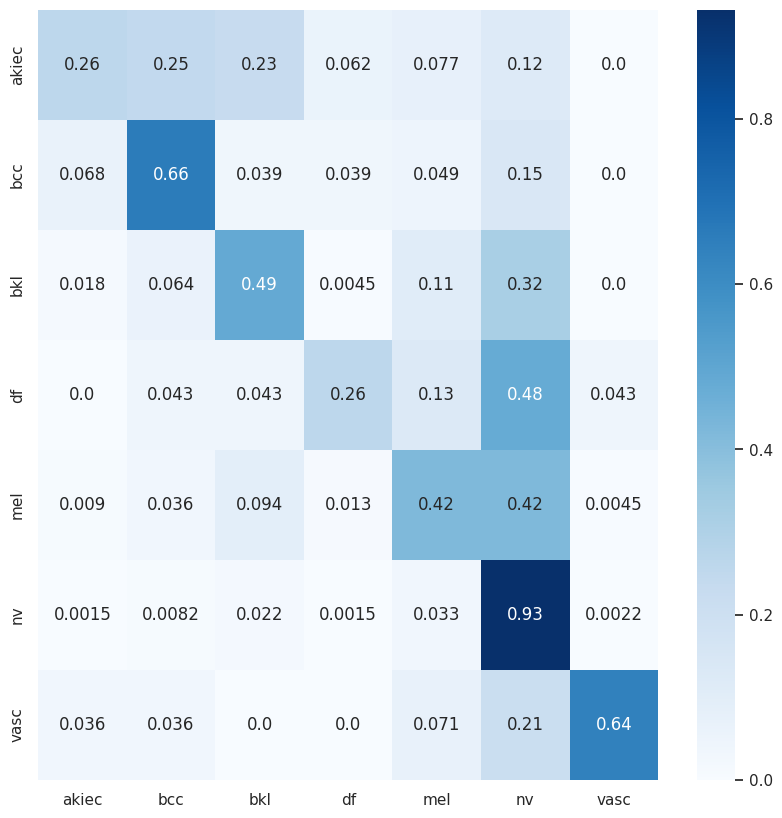

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames ) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


121/121 [==============================] - 8s 63ms/step


In [ ]:
# 50% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 58% 487


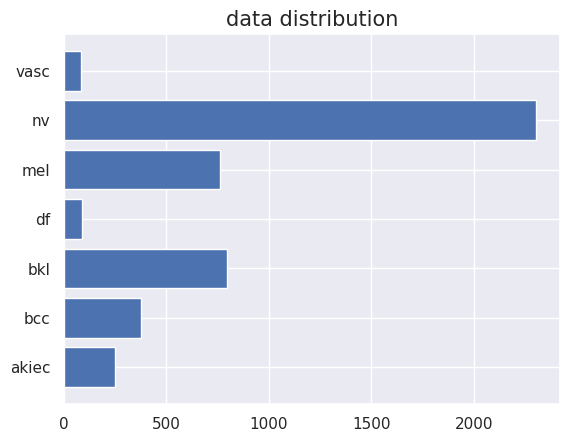

In [ ]:

## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
233/233 [==============================] - 12s 52ms/step - loss: 0.2721 - accuracy: 0.9280 - precision: 0.9304 - recall: 0.8846
Epoch 2/12
233/233 [==============================] - 10s 43ms/step - loss: 0.2208 - accuracy: 0.9394 - precision: 0.9256 - recall: 0.9349
Epoch 3/12
233/233 [==============================] - 10s 43ms/step - loss: 0.2050 - accuracy: 0.9431 - precision: 0.9157 - recall: 0.9448
Epoch 4/12
233/233 [==============================] - 10s 43ms/step - loss: 0.1895 - accuracy: 0.9532 - precision: 0.9412 - recall: 0.9321
Epoch 5/12
233/233 [==============================] - 10s 42ms/step - loss: 0.1665 - accuracy: 0.9588 - precision: 0.9429 - recall: 0.9499
Epoch 6/12
233/233 [==============================] - 10s 42ms/step - loss: 0.1488 - accuracy: 0.9639 - precision: 0.9583 - recall: 0.9474
Epoch 7/12
233/233 [==============================] - 10s 42ms/step - loss: 0.1518 - accuracy: 0.9573 - precision: 0.9451 - recall: 0.9502
Epoch 8/12
233/233 [=======

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))

63/63 [==============================] - 3s 49ms/step
              precision    recall  f1-score   support

           0       0.40      0.37      0.38        65
           1       0.46      0.61      0.53       103
           2       0.56      0.45      0.50       220
           3       0.60      0.39      0.47        23
           4       0.59      0.44      0.51       223
           5       0.88      0.93      0.90      1341
           6       0.88      0.79      0.83        28

   micro avg       0.78      0.78      0.78      2003
   macro avg       0.62      0.57      0.59      2003
weighted avg       0.77      0.78      0.77      2003
 samples avg       0.78      0.78      0.78      2003



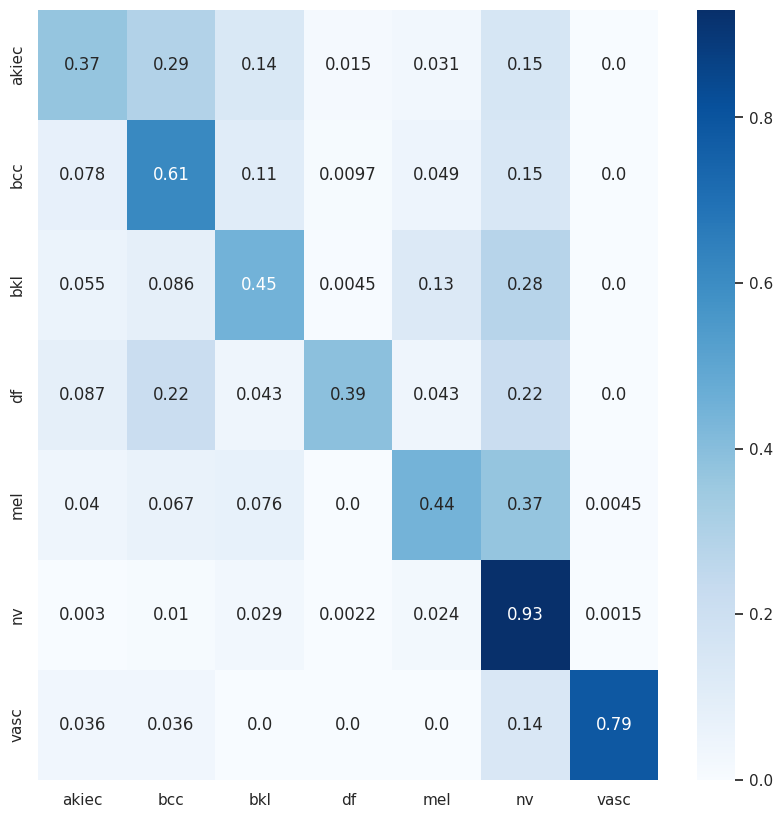

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames ) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


105/105 [==============================] - 7s 71ms/step


In [ ]:
# 55% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 63% 424


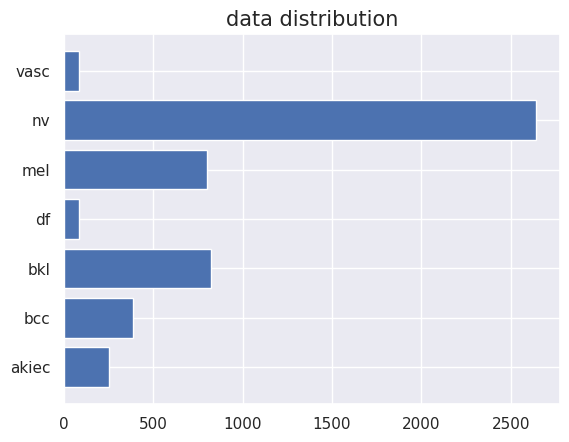

In [ ]:

## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
254/254 [==============================] - 11s 43ms/step - loss: 0.1769 - accuracy: 0.9535 - precision: 0.9323 - recall: 0.9571
Epoch 2/12
254/254 [==============================] - 11s 42ms/step - loss: 0.1867 - accuracy: 0.9518 - precision: 0.9328 - recall: 0.9405
Epoch 3/12
254/254 [==============================] - 11s 43ms/step - loss: 0.1797 - accuracy: 0.9510 - precision: 0.9329 - recall: 0.9464
Epoch 4/12
254/254 [==============================] - 11s 42ms/step - loss: 0.1617 - accuracy: 0.9587 - precision: 0.9395 - recall: 0.9514
Epoch 5/12
254/254 [==============================] - 11s 43ms/step - loss: 0.1752 - accuracy: 0.9512 - precision: 0.9359 - recall: 0.9488
Epoch 6/12
254/254 [==============================] - 11s 42ms/step - loss: 0.1489 - accuracy: 0.9626 - precision: 0.9471 - recall: 0.9547
Epoch 7/12
254/254 [==============================] - 11s 43ms/step - loss: 0.1382 - accuracy: 0.9638 - precision: 0.9473 - recall: 0.9585
Epoch 8/12
254/254 [=======

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

print(classification_report(TAR_Test, pred_test))

63/63 [==============================] - 3s 49ms/step
              precision    recall  f1-score   support

           0       0.40      0.58      0.48        65
           1       0.55      0.46      0.50       103
           2       0.57      0.45      0.50       220
           3       0.44      0.48      0.46        23
           4       0.60      0.49      0.54       223
           5       0.87      0.92      0.90      1341
           6       0.88      0.79      0.83        28

   micro avg       0.78      0.78      0.78      2003
   macro avg       0.62      0.60      0.60      2003
weighted avg       0.77      0.78      0.77      2003
 samples avg       0.78      0.78      0.78      2003



In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


92/92 [==============================] - 7s 74ms/step


### AUGMENTATION AND BINARY EXPERIMENT

In [ ]:
# ### REGULAR AUGMENTATION FUNCTION

# DEFINING IMAGE AUGMENTATION FUNCTION
# Normal
def normal (img):
    return(img)

# rotate
def rotate (img):
    return(np.rot90(img))

# rotate 180
def rotate180(img):
    img = np.rot90(img)
    return(np.rot90(img))

# image zoom +1
resize_width = 128
resize_height = 128
def zoom1 (img):
    img = img[4:(resize_height-4), 4:(resize_width-4)]
    return (cv2.resize(img, (resize_width, resize_height)))

# image zoom +2
resize_width = 128
resize_height = 128
def zoom2 (img):
    img = img[16:(resize_height-16), 16:(resize_width-16)]
    return (cv2.resize(img, (resize_width, resize_height)))

#tilt from opencv tutorials
def tilt (img):
    pts1 = np.float32([[16,16],[100,16],[16,100]])
    pts2 = np.float32([[2,64],[64,16],[64,128]])
    M = cv2.getAffineTransform(pts1,pts2)
    dst = cv2.warpAffine(img,M,(128,128))
    return(dst)

# padding right and up
def shiftright (img):
    resize_width = 128
    resize_height = 128
    img = img[16:(resize_height), 16:(resize_width)]
    return (cv2.resize(img, (resize_width, resize_height)))

# padding left and down
def shiftleft (img):
    resize_width = 128
    resize_height = 128
    img = img[0:(resize_height-16), 0:(resize_width-16)]
    return (cv2.resize(img, (resize_width, resize_height)))

functionslist = [normal,rotate,rotate180,zoom1,zoom2,tilt,shiftright,shiftleft]
# note that normal will repeated 50% of the time to reduce effect of the augmentation on the final experiment


# In[124]:


import random

def aug_generator(imgs,targets,rate=1):
    imagelist = []
    targetlist = []
    for i in range(len(imgs)):
        for x in range(rate):
            targetlist.append(targets[i])
            augimg = list(map(functionslist[random.randint(0,7)],[imgs[i]]))[0]   # note function list defined globally
            imagelist.append(augimg)

    suffle_index=[i for i in range(len(imagelist))]
    random.shuffle(suffle_index)
    return(np.array(imagelist)[suffle_index],np.array(targetlist)[suffle_index])


# In[ ]:

<a id='diversity_with_aug'></a>
### DIVERSITY WITH AUGUMENTATION

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[103]:


from keras.layers import Input, Dense, Reshape, Flatten,Reshape
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
import sys
import numpy as np
import cv2
import random


# In[43]:


def dimensions():
    img_rows = 128
    img_cols = 128
    channels = 3
    global img_shape , z_dim
    img_shape = (img_rows, img_cols, channels)
    z_dim = 100


# Generator Network

# In[44]:


def generat(img_shape, z_dim):
    
    model = Sequential()
    
    # Hidden layer
    model.add(Dense(128, input_dim=z_dim))
    model.add(Dense(512*2 ))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with tanh activation
    model.add(Dense(128*128*3, activation='tanh'))  # SEE HOW OUTPUT IS A 128*128*3 OUTPUTS CORRESPONDING TO PIXEL POSITION
    model.add(Reshape(img_shape))

    z = Input(shape=(z_dim))
    img = model(z)

    return Model(z, img)


# Discriminator Network

# In[45]:


def discriminat(img_shape):
    
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    # Hidden layer
    model.add(Dense(128))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    prediction = model(img)

    return Model(img, prediction)


# In[46]:


def discriminator_generator():
    global discriminator, generator,z, img,prediction,combined,losses,accuracies
    discriminator = discriminat(img_shape)
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer='adam', metrics=['accuracy'])

    # Build the Generator
    generator = generat(img_shape, z_dim)

    # Generated image to be used as input
    z = Input(shape=(100,))
    img = generator(z)

    # Keep Discriminator’s parameters constant during Generator training
    discriminator.trainable = False

    # The Discriminator’s prediction
    prediction = discriminator(img)

    # Combined GAN model to train the Generator
    combined = Model(z, prediction)
    combined.compile(loss='binary_crossentropy', optimizer='adam')
    #generator.compile(loss='categorical_crossentropy', optimizer='adam')

    losses = []
    accuracies = []


# GAN Training function

# In[69]:




def train(train_images,iterations, batch_size, sample_interval):
    
    
    X_train = train_images
    data_slice = 5
#    X_train = X_train[:data_slice,:]
    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
#    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        
        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Select a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
#        generator.train_on_batch(z,imgs)

        # Discriminator loss
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = np.add(d_loss_real, d_loss_fake)/2
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Generator loss
        g_loss = combined.train_on_batch(z, real)

        if iteration < 2:
            
            # Output training progress
            print ("Start %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))
            
#             # Save losses and accuracies so they can be plotted after training
#             losses.append((d_loss[0], g_loss))
#             accuracies.append(100*d_loss[1])

#             # Output generated image samples 
#             sample_images(iteration)
    print ("End %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))


# In[70]:


def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, 
              (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise 
    gen_imgs = generator.predict(z)

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5

    
    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                    figsize=(8,8), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output image grid
            axs[i,j].imshow(gen_imgs[cnt, :,:,0])
            axs[i,j].axis('off')
            cnt += 1


# In[71]:


import warnings; warnings.simplefilter('ignore')


# GAN Training

# In[63]:


# iterations = 100
# batch_size = 5
# sample_interval = 5

# # Train the GAN for the specified number of iterations
# train(iterations, batch_size, sample_interval)


# In[90]:


# IMAGES = np.load("IMAGE.npy")
# IMAGES.shape


# In[91]:


# TAR = np.ones((10,1))
# TAR


# * train on selected class
# * generated and return given augmented images

# In[131]:


def GAN_generator(train_images,batch_size,amount):
    dimensions()
    discriminator_generator()
    iterations = 100
    train(train_images,iterations, batch_size, sample_interval = 5)
    z =  np.random.normal(0, 1, (amount, 100))
    return(generator.predict(z))


# In[ ]:

# content
   1. [Import Library and mount google drive](#importing_libraries)
   2. [Load HAM10K data set to memory](#loading_dataset)
   3. [Describe general Active learn Process Flow](#process_flow)
   4. [description of core feature DIVERSITY(uncertainty) Strategy](#Diversity)
   5. [8*RUNS of experiment for statistical confidence](#runs)
       * reset train/test split 
       * starting from 10% 
       * Visualize how strategy is sampling through imbalanced dataset
       * test on testset at every step and document result

       

<a id='importing_libraries'></a>
### IMPORTING SOME LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib 
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import time

from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,ZeroPadding2D,Input #importing some cool keras layers 1st
import random

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:

os.chdir('gdrive/MyDrive/3PROJECT')
#os.listdir()
#os.getcwd()

<a id='loading_dataset'></a>
### HAM10000 DATASET LOAD

APPROACH A: load data in from both folders in to a REPO in script memory

then while loading each file; match file name with csv and load Target to a TAR file also in memory

In [ ]:
# reading target source file into dataframe
skin_df = pd.read_csv('HAM10000/HAM10000_metadata.csv')

In [ ]:
# this data is stored in a local directory "HAM10000"
# using os to locate files and cv2 to read into Numpy arrays
resize_width = 128
resize_height = 128
path = "HAM10000"
IMAGE = [] # List to append the images as 2D numpy arrays.
TARGET = [] # List to append the target all ch


for root, dirs, files in os.walk(path):
     for file in files:
         if '(1)' not in file:
             with open(os.path.join(root, file), "r") as auto:
                 try:
              
                     img = cv2.imread(root+'/'+file)   # cv2 reads image to a 2d ie grayscale=0 full_RGB = _default_blank_
                     img = cv2.resize(img, (resize_width, resize_height)) # image resize to 128/128
                     IMAGE.append(img)
                     # Append the folder where the image is to the target list
                     TARGET.append(list(skin_df.dx[skin_df.image_id == file.replace('.jpg','')])[0])
                 except Exception as e:
                     print("Invalid file "+file+" skipped.")

for part in np.unique(TARGET):
    print ('{} has {} images'.format(part,TARGET.count(part)))
print("TOTAL IMAGES =",len(TARGET))

Invalid file HAM10000_metadata.csv skipped.
Invalid file hmnist_28_28_L.csv skipped.
Invalid file hmnist_8_8_L.csv skipped.
Invalid file hmnist_8_8_RGB.csv skipped.
Invalid file hmnist_28_28_RGB.csv skipped.
akiec has 327 images
bcc has 514 images
bkl has 1099 images
df has 115 images
mel has 1113 images
nv has 6705 images
vasc has 142 images
TOTAL IMAGES = 10015


In [ ]:
IMAGE[0].shape

(128, 128, 3)

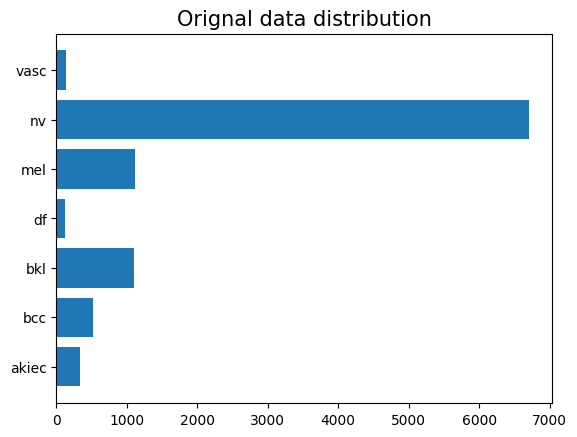

In [ ]:
## showing distribution
parts = np.unique(TARGET)
count=[]
for part in parts:
    count.append(TARGET.count(part))
plt.barh(parts,count)
plt.title("Orignal data distribution",size = 15)
plt.show()

Text(0.5, 0, 'nv             nv               nv  ')

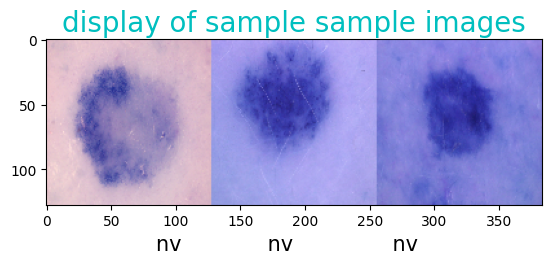

In [ ]:
im_sample=np.concatenate((IMAGE[0],IMAGE[5010],IMAGE[10000]),axis=1)
plt.imshow(im_sample)
plt.title("display of sample sample images",size=20,color="c")
plt.xlabel("{}             {}               {}  ".format(TARGET[0],TARGET[5010],TARGET[10000]),size=15)

In [ ]:
# RENAMING TARGET LABELS so TARGET CAN WORK WITH A CLASSIFIER ALOGRITHM
def re_label(targets):
    TAR=[]
    for part in targets:
        if part == 'akiec':
            TAR.append(0)
        elif part == 'bcc':
            TAR.append(1)
        elif part == 'bkl':
            TAR.append(2)
        elif part == 'df':
            TAR.append(3)
        elif part == 'mel':
            TAR.append(4)
        elif part == 'nv':
            TAR.append(5)
        else:
            TAR.append(6)
    return (TAR)
TARo = re_label(TARGET)

## reverse np labels
def revs_label(np_targets):
    Target=[]
    for part in np_targets:
        if part[0] == 1:
            Target.append('akiec')
        elif part[1] == 1:
            Target.append('bcc')
        elif part[2] == 1:
            Target.append('bkl')
        elif part[3] == 1:
            Target.append('df')
        elif part[4] == 1:
            Target.append('mel')
        elif part[5] == 1:
            Target.append('nv')
        elif part[6] == 1:
            Target.append('vasc')
    return (Target)

In [ ]:
# CONFUSION MATRIX FUNCTION
def plot_confusion_matrix(y_test,y_scores, classNames):
    y_test=np.argmax(y_test, axis=1)
    y_scores=np.argmax(y_scores, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]/np.sum(cm[x,:])

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1) # for label size
    df = sns.heatmap(con, annot=True,fmt='.2', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
classNames = ['akiec','bcc','bkl','df','mel','nv','vasc'] 
# source https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels

<a id='process_flow'></a>
### ACTIVE LEARNING (AL) PROCESS FLOW 
**Require :**
1. initial labeled set for training ***IMAGES_L, TARGET_L***
2. Unlabeled for test ***IMAGES_U***
3. based on initial trained model ***ModelAL*** certain batch to be auto-label and absorbed
4. informative batch to be query ***x_batch*** and get ***y*** from ORACLE ***O_Target*** 
5. add ***x_batch*** to Labeled training set ***L*** (IMAGES and TARGET)
6. remove ***x_batch*** from Unlabeled ***IMAGES_U***
7. retraining model ***ModelAL***
8. testing model ***ModelAL***  on test set
9. reach final model ***M***


<a id='Diversity'></a>
### THE DIVERSITY(uncertainty) Strategy

#### S_SOFT: defining activation function that enables me deduct class polarity of instance predictions 

In [ ]:
def s_soft(x):
    return((tf.keras.activations.softsign(x)+1)/2)

#### Difference between softmax and s_soft from keras.activations.softsign

* "softmax" creates a probability representation from 0 to 1 on predicted instance while "softsign" show similar probability but allowing -ve activation to maintain sign, because Keras model required for a training model the activation to be +ve and between 0 to 1; create the activation from s_soft for softsign that i can scale back to allow me see those instances that orginally had -ve activation

***Plan***

1. with the s_soft activation: from our prediction on the unlabeled class, see can easily see and deduce that any value below 0.5 was -ve
2. a -ve score from a NN may mean that, the Network hasn't got a lot of information in that feature space
3. in theory, such instances have most information 
4. the plan is to exhaust this diverse instances then proceed to fetching blanket uncertainty





In [ ]:
# DIVERSITY FUNCTION
# USING THE FACT THAT CLASSES BELOW 0.5 ARE EQUVALENT TO -VE LOGITS FROM THE softsign RESULT THE FUNCTION HERE PRIORITIZE INSTANCE WITH -VE LOGIST FIRST
# AND WHEN SUCH SAMPLES IS EXHUSTED THE FUNCTION RESULT BACK TO LEAST CONFIDENCE
def get_diverse_batch(percent): 
    Per = len(TAR)*percent/100
    uncertainty = 0.5
    batch=[]
    
    while (len(batch) < Per)&(len(predAL)>Per):
        batch=[]
        margin = 0.9
        if uncertainty <= 0.5:
            while (margin > 0.05):
                batch=[]
                for i in range (len(predAL)):
                    y = list(predAL[i])
                    y.sort(reverse = True)
                    if (y[0] < uncertainty) & ((y[0]-y[1])>margin): 
                        batch.append(i)
                    if len(batch) >= Per:
                        break
                margin = margin*4/5

            if (len(batch) < Per):
                uncertainty+= 0.001
                
        else:   
            for i in range (len(predAL)):
                y = max(list(predAL[i]))
                if y < uncertainty: 
                    batch.append(i)
            uncertainty+= 0.001
    return (batch)

<a id='runs'></a>
### FIRST RUN

* run random, 
* figure out which class requires Support form test results rather than training
* run diversity sampling and prepare new training set IMAGES_L
* run augmentation on class selected at optimal rate
* concatination with training Images_L



In [ ]:
# CREATING MAIN TEST SET 10% DATASET
# also setting  seed (for reproducibility)
np.random.seed(101)

IMAGES,IMAGES_Test,TAR_Train,TARGET_Test_M = train_test_split(IMAGE,TARo,stratify=TARo,test_size=0.2)



# reshaping data for Neural Network
IMAGES = np.array(IMAGES,dtype='float64').reshape(len(IMAGES), 128, 128, 3)

IMAGES_Test = np.array(IMAGES_Test,dtype='float64').reshape(len(IMAGES_Test), 128, 128, 3)

# changing labels to array like categorical labels vital for CNN training
TAR = np_utils.to_categorical(TAR_Train, 7)
TAR_Test = np_utils.to_categorical(TARGET_Test_M, 7)  # creating categorical output for test data


# normalising
IMAGES_Test /= 255
IMAGES /= 255

##### AL Starting with a Random 10% Sample 

In [ ]:
np.random.seed(101)
r = 0.1  # 10% START TRAINING SET
IMAGES_L,IMAGES_U,TARGET_L,TARGET_O = train_test_split(IMAGES,TAR,stratify=TAR,test_size=(1-r))

print("RANDOM SAMPLED START TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)))

# IMAGES_L: initial labeled set for training L
# IMAGES_U: Unlabeled for pool U
# TARGET_L: corresponding target for L
# TARGET_O: ORACLE for Unlabeled pool U

RANDOM SAMPLED START TRAINING SET AT 10%


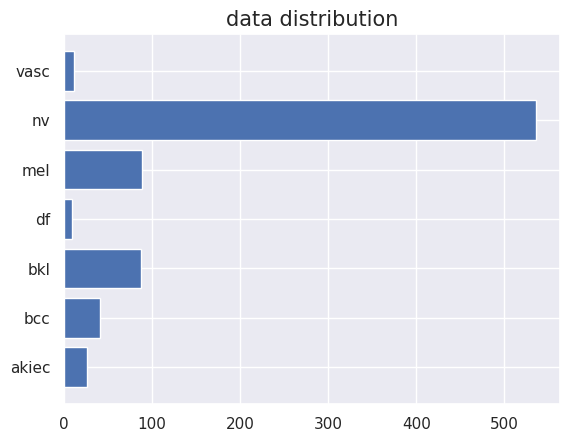

In [ ]:
## showing distribution
TargetAL = revs_label(TARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
modelAL = Sequential()

pretrained_model= tf.keras.applications.DenseNet201(
    include_top=False,
    input_shape=(128,128,3),
    pooling='avg',
    classes=1000,
    weights='imagenet',
)                     # 

for each_layer in pretrained_model.layers[:-25]:  # 20 BOTH 78%

        each_layer.trainable=False                             # runs a for loop to change setting on layers in model not to retrain

modelAL.add(pretrained_model)


modelAL.add(Flatten())

modelAL.add(Dense(512, activation='relu'))

modelAL.add(Dense(7, activation=s_soft))

In [ ]:
modelAL.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Precision','Recall'])

In [ ]:
# TRAINING
modelAL.fit(IMAGES_L,np.array(TARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
41/41 [==============================] - 15s 45ms/step - loss: 1.1068 - accuracy: 0.6592 - precision: 0.5341 - recall: 0.7441
Epoch 2/12
41/41 [==============================] - 2s 43ms/step - loss: 0.8611 - accuracy: 0.6692 - precision: 0.5521 - recall: 0.8539
Epoch 3/12
41/41 [==============================] - 2s 42ms/step - loss: 0.7859 - accuracy: 0.6717 - precision: 0.5222 - recall: 0.8964
Epoch 4/12
41/41 [==============================] - 2s 42ms/step - loss: 0.7035 - accuracy: 0.6929 - precision: 0.5581 - recall: 0.9238
Epoch 5/12
41/41 [==============================] - 2s 44ms/step - loss: 0.6333 - accuracy: 0.6879 - precision: 0.6087 - recall: 0.9126
Epoch 6/12
41/41 [==============================] - 2s 43ms/step - loss: 0.5861 - accuracy: 0.7291 - precision: 0.6113 - recall: 0.9326
Epoch 7/12
41/41 [==============================] - 2s 44ms/step - loss: 0.5890 - accuracy: 0.8027 - precision: 0.6289 - recall: 0.9226
Epoch 8/12
41/41 [=============================

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

report = classification_report(TAR_Test, pred_test)
print(report)

63/63 [==============================] - 6s 51ms/step
              precision    recall  f1-score   support

           0       0.24      0.23      0.24        65
           1       0.36      0.57      0.44       103
           2       0.34      0.60      0.44       220
           3       0.20      0.04      0.07        23
           4       0.26      0.30      0.28       223
           5       0.89      0.75      0.81      1341
           6       0.89      0.29      0.43        28

   micro avg       0.64      0.64      0.64      2003
   macro avg       0.45      0.40      0.39      2003
weighted avg       0.71      0.64      0.66      2003
 samples avg       0.64      0.64      0.64      2003



![DIVERSITY](CODE/Diversity_Aug.jpg)

In [ ]:
# FINDING CLASS WITH LOWEST F1-SCORE from test result
def get_hardest_class(report):
    lines=report.split("\n")
    line_list = [line.split("      ") for line in lines]
    line_list = [[float(x) for x in lists[1:5]] for lists in line_list[2:9]]
    line_array = np.array(line_list)
    hard_class = int(line_array[:,0][line_array[:,3] == line_array[:,3].min()][0]) # pick the first class if two
    return(hard_class)
hard_class = get_hardest_class(report)
print("the hardest class is ",revs_label( [ np_utils.to_categorical(hard_class, 7)]))

the hardest class is  ['df']


In [ ]:
# PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)


226/226 [==============================] - 11s 50ms/step


In [ ]:
# 15% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))


RANDOM SAMPLED NOW TRAINING SET AT 18% 615


In [ ]:
# AUGMENT THE CLASS WITH  LEAST F1 SCORE

#selecting existing data in Training set L to Augment
hc=[]
for i in range(len(TARGET_L)):
    if (TARGET_L[i][hard_class] == 1) :
        hc.append(i)
        
hc_IMAGES = IMAGES_L[hc]
hc_TAR = TARGET_L[hc]

In [ ]:
len(hc)

32

In [ ]:
import AUG_Fil
from AUG_Fil import GAN_generator,aug_generator


amount=len(hc)

aug_img_dic = {}
aug_tar_dic = {}

if len(hc) < len(TARGET_L)/7:
    rate= 1
else:
    rate= 0
aug_img_dic[hard_class],aug_tar_dic[hard_class] = aug_generator(hc_IMAGES,hc_TAR,rate=1)

# ADDING AGUMENTED DATASET TO CURRENT TRAINING SET L

aIMAGES_L = IMAGES_L
aTARGET_L = TARGET_L

In [ ]:
# CONCATINATE WITH TRAINING BATCH AND TRAIN
for i in aug_img_dic.keys():
    aIMAGES_L= np.concatenate((aIMAGES_L,aug_img_dic[i]), axis=0)
    aTARGET_L= np.concatenate((aTARGET_L,aug_tar_dic[i]), axis=0)

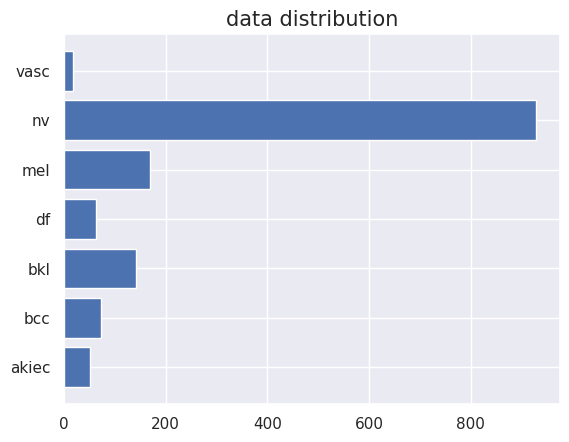

In [ ]:

## showing distribution
TargetAL = revs_label(aTARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(aIMAGES_L,np.array(aTARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
73/73 [==============================] - 3s 44ms/step - loss: 0.8120 - accuracy: 0.7479 - precision: 0.7716 - recall: 0.6858
Epoch 2/12
73/73 [==============================] - 3s 43ms/step - loss: 0.6118 - accuracy: 0.8052 - precision: 0.8389 - recall: 0.7410
Epoch 3/12
73/73 [==============================] - 3s 43ms/step - loss: 0.4820 - accuracy: 0.8529 - precision: 0.8729 - recall: 0.8018
Epoch 4/12
73/73 [==============================] - 3s 42ms/step - loss: 0.3937 - accuracy: 0.8833 - precision: 0.8841 - recall: 0.8584
Epoch 5/12
73/73 [==============================] - 3s 42ms/step - loss: 0.3347 - accuracy: 0.9130 - precision: 0.8933 - recall: 0.8957
Epoch 6/12
73/73 [==============================] - 3s 42ms/step - loss: 0.2939 - accuracy: 0.9268 - precision: 0.9091 - recall: 0.9047
Epoch 7/12
73/73 [==============================] - 3s 44ms/step - loss: 0.2348 - accuracy: 0.9454 - precision: 0.9570 - recall: 0.9075
Epoch 8/12
73/73 [==============================

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

report = classification_report(TAR_Test, pred_test)
print(report)

63/63 [==============================] - 3s 49ms/step
              precision    recall  f1-score   support

           0       0.35      0.42      0.38        65
           1       0.58      0.41      0.48       103
           2       0.50      0.53      0.51       220
           3       1.00      0.17      0.30        23
           4       0.43      0.27      0.33       223
           5       0.85      0.92      0.88      1341
           6       0.67      0.57      0.62        28

   micro avg       0.75      0.75      0.75      2003
   macro avg       0.62      0.47      0.50      2003
weighted avg       0.73      0.75      0.73      2003
 samples avg       0.75      0.75      0.75      2003



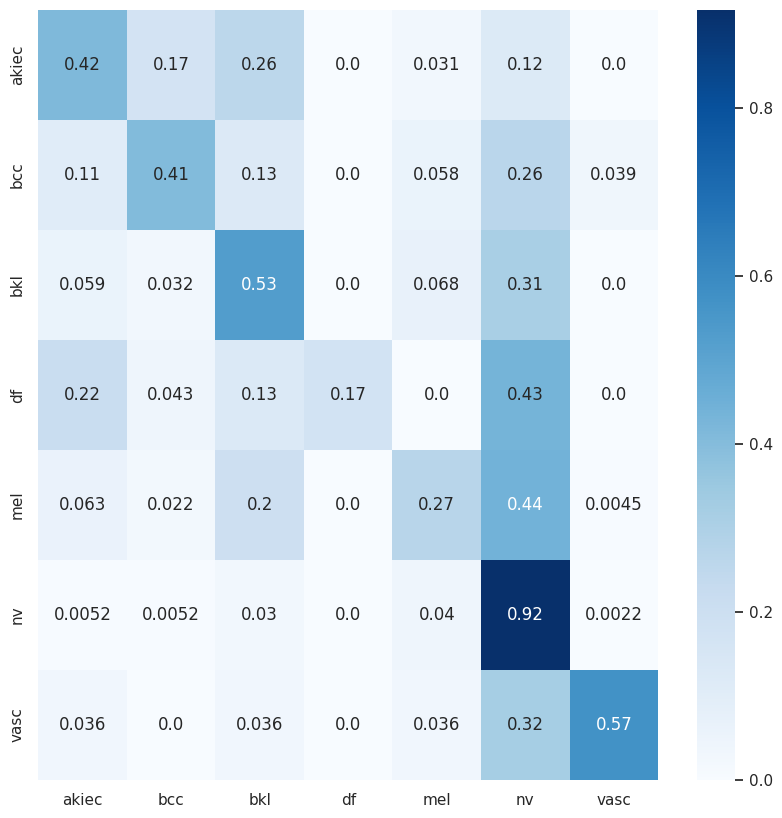

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames ) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


213/213 [==============================] - 13s 60ms/step


In [ ]:
# 20% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 22% 593


#### GET HARDEST CLASS FROM REPORT AND AUGMENT

In [ ]:
#GET HARDEST CLASS FROM REPORT AND AUGMENT
hard_class = get_hardest_class(report)
print("the hardest class is ",revs_label( [ np_utils.to_categorical(hard_class, 7)]))

#selecting existing data in Training set L to Augment
hc=[]
for i in range(len(TARGET_L)):
    if (TARGET_L[i][hard_class] == 1) :
        hc.append(i)
        
hc_IMAGES = IMAGES_L[hc]
hc_TAR = TARGET_L[hc]

#CREATING AUGMENTED DATA
if len(hc) < len(TARGET_L)/7:
    rate= 1
else:
    rate= 0   # no need to augment class with large ratio of data
aug_img_dic[hard_class],aug_tar_dic[hard_class] = aug_generator(hc_IMAGES,hc_TAR,rate=rate)

# ADDING AGUMENTED DATASET TO CURRENT TRAINING SET L

aIMAGES_L = IMAGES_L
aTARGET_L = TARGET_L

for i in aug_img_dic.keys():
    aIMAGES_L= np.concatenate((aIMAGES_L,aug_img_dic[i]), axis=0)
    aTARGET_L= np.concatenate((aTARGET_L,aug_tar_dic[i]), axis=0)

the hardest class is  ['df']


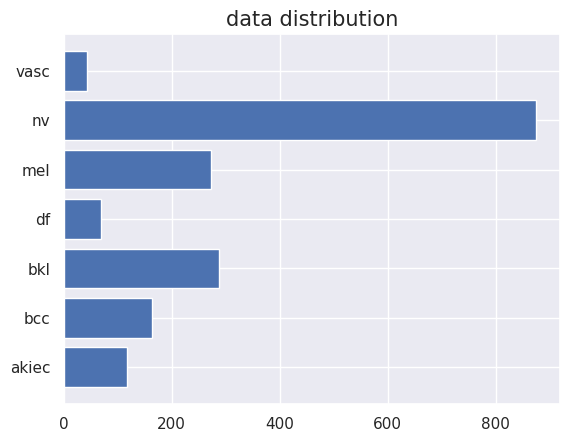

In [ ]:

## showing distribution
TargetAL = revs_label(aTARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(aIMAGES_L,np.array(aTARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
92/92 [==============================] - 6s 63ms/step - loss: 0.8120 - accuracy: 0.7383 - precision: 0.8402 - recall: 0.6208
Epoch 2/12
92/92 [==============================] - 4s 42ms/step - loss: 0.6742 - accuracy: 0.7962 - precision: 0.8425 - recall: 0.7251
Epoch 3/12
92/92 [==============================] - 4s 41ms/step - loss: 0.5296 - accuracy: 0.8415 - precision: 0.8858 - recall: 0.7628
Epoch 4/12
92/92 [==============================] - 4s 42ms/step - loss: 0.4479 - accuracy: 0.8639 - precision: 0.8579 - recall: 0.8383
Epoch 5/12
92/92 [==============================] - 4s 43ms/step - loss: 0.3640 - accuracy: 0.8934 - precision: 0.9034 - recall: 0.8530
Epoch 6/12
92/92 [==============================] - 4s 41ms/step - loss: 0.2783 - accuracy: 0.9333 - precision: 0.9448 - recall: 0.8798
Epoch 7/12
92/92 [==============================] - 4s 41ms/step - loss: 0.2571 - accuracy: 0.9339 - precision: 0.9425 - recall: 0.9038
Epoch 8/12
92/92 [==============================

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

report = classification_report(TAR_Test, pred_test)
print(report)

63/63 [==============================] - 3s 49ms/step
              precision    recall  f1-score   support

           0       0.31      0.40      0.35        65
           1       0.47      0.59      0.52       103
           2       0.56      0.44      0.49       220
           3       0.80      0.17      0.29        23
           4       0.47      0.40      0.43       223
           5       0.87      0.91      0.89      1341
           6       0.87      0.71      0.78        28

   micro avg       0.76      0.76      0.76      2003
   macro avg       0.62      0.52      0.54      2003
weighted avg       0.75      0.76      0.75      2003
 samples avg       0.76      0.76      0.76      2003



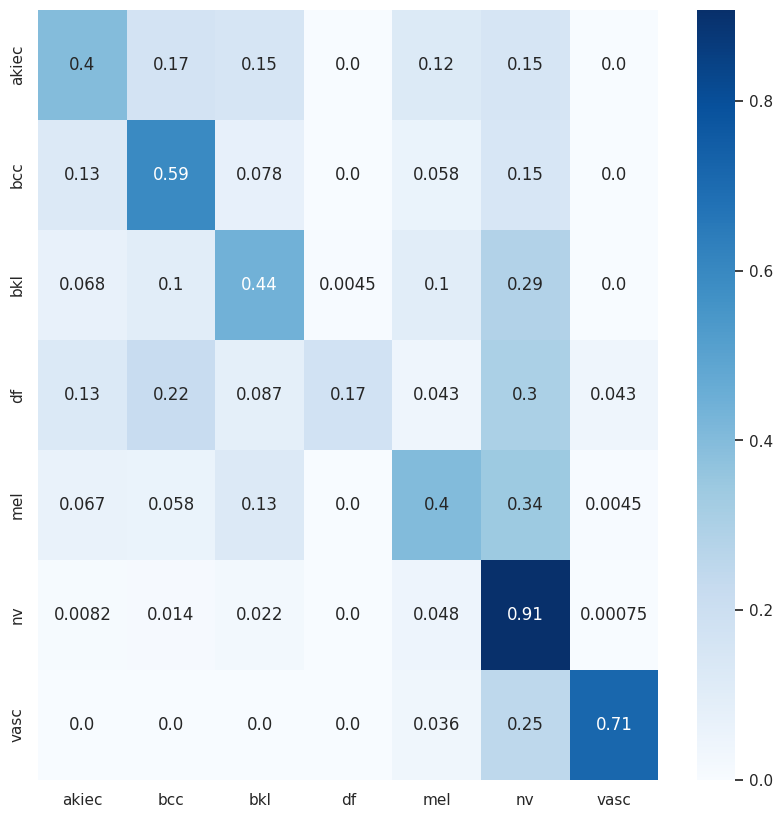

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


195/195 [==============================] - 10s 49ms/step


In [ ]:
# 25% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 28% 427


In [ ]:
#GET HARDEST CLASS FROM REPORT AND AUGMENT
hard_class = get_hardest_class(report)
print("the hardest class is ",revs_label( [ np_utils.to_categorical(hard_class, 7)]))

#selecting existing data in Training set L to Augment
hc=[]
for i in range(len(TARGET_L)):
    if (TARGET_L[i][hard_class] == 1) :
        hc.append(i)
        
hc_IMAGES = IMAGES_L[hc]
hc_TAR = TARGET_L[hc]

#CREATING AUGMENTED DATA
if len(hc) < len(TARGET_L)/7:
    rate= 1
else:
    rate= 0   # no need to augment class with large ratio of data
aug_img_dic[hard_class],aug_tar_dic[hard_class] = aug_generator(hc_IMAGES,hc_TAR,rate=rate)

# ADDING AGUMENTED DATASET TO CURRENT TRAINING SET L

aIMAGES_L = IMAGES_L
aTARGET_L = TARGET_L

for i in aug_img_dic.keys():
    aIMAGES_L= np.concatenate((aIMAGES_L,aug_img_dic[i]), axis=0)
    aTARGET_L= np.concatenate((aTARGET_L,aug_tar_dic[i]), axis=0)

the hardest class is  ['df']


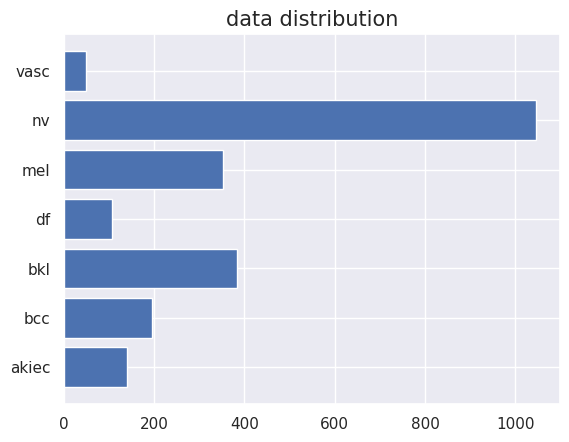

In [ ]:

## showing distribution
TargetAL = revs_label(aTARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(aIMAGES_L,np.array(aTARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
132/132 [==============================] - 7s 53ms/step - loss: 0.5761 - accuracy: 0.8341 - precision: 0.8065 - recall: 0.8360
Epoch 2/12
132/132 [==============================] - 6s 42ms/step - loss: 0.4543 - accuracy: 0.8711 - precision: 0.8706 - recall: 0.8394
Epoch 3/12
132/132 [==============================] - 5s 42ms/step - loss: 0.3878 - accuracy: 0.8970 - precision: 0.8477 - recall: 0.8936
Epoch 4/12
132/132 [==============================] - 6s 42ms/step - loss: 0.3523 - accuracy: 0.9001 - precision: 0.9111 - recall: 0.8600
Epoch 5/12
132/132 [==============================] - 6s 43ms/step - loss: 0.2754 - accuracy: 0.9241 - precision: 0.9240 - recall: 0.8997
Epoch 6/12
132/132 [==============================] - 6s 42ms/step - loss: 0.2688 - accuracy: 0.9287 - precision: 0.9315 - recall: 0.8974
Epoch 7/12
132/132 [==============================] - 6s 43ms/step - loss: 0.2522 - accuracy: 0.9321 - precision: 0.9019 - recall: 0.9260
Epoch 8/12
132/132 [==============

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

report = classification_report(TAR_Test, pred_test)
print(report)

63/63 [==============================] - 3s 50ms/step
              precision    recall  f1-score   support

           0       0.38      0.20      0.26        65
           1       0.59      0.49      0.53       103
           2       0.61      0.49      0.54       220
           3       0.71      0.22      0.33        23
           4       0.33      0.54      0.41       223
           5       0.88      0.86      0.87      1341
           6       0.70      0.57      0.63        28

   micro avg       0.73      0.73      0.73      2003
   macro avg       0.60      0.48      0.51      2003
weighted avg       0.75      0.73      0.74      2003
 samples avg       0.73      0.73      0.73      2003



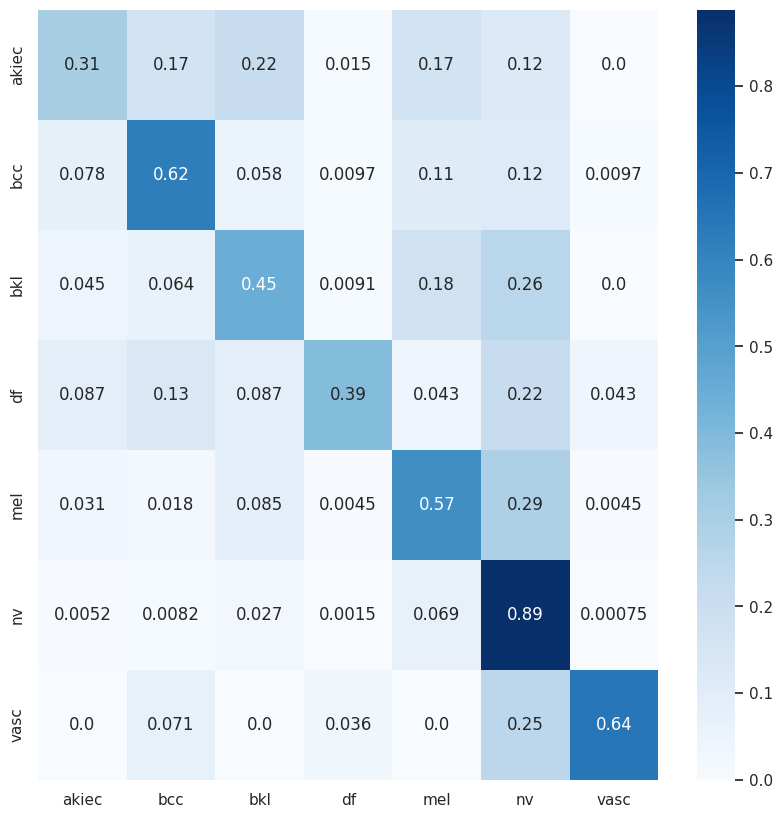

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


188/188 [==============================] - 9s 50ms/step


In [ ]:
# 30% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 36% 478


In [ ]:
#GET HARDEST CLASS FROM REPORT AND AUGMENT
hard_class = get_hardest_class(report)
print("the hardest class is ",revs_label( [ np_utils.to_categorical(hard_class, 7)]))

#selecting existing data in Training set L to Augment
hc=[]
for i in range(len(TARGET_L)):
    if (TARGET_L[i][hard_class] == 1) :
        hc.append(i)
        
hc_IMAGES = IMAGES_L[hc]
hc_TAR = TARGET_L[hc]

#CREATING AUGMENTED DATA
if len(hc) < len(TARGET_L)/7:
    rate= 1
else:
    rate= 0   # no need to augment class with large ratio of data
aug_img_dic[hard_class],aug_tar_dic[hard_class] = aug_generator(hc_IMAGES,hc_TAR,rate=1)

# ADDING AGUMENTED DATASET TO CURRENT TRAINING SET L

aIMAGES_L = IMAGES_L
aTARGET_L = TARGET_L

for i in aug_img_dic.keys():
    aIMAGES_L= np.concatenate((aIMAGES_L,aug_img_dic[i]), axis=0)
    aTARGET_L= np.concatenate((aTARGET_L,aug_tar_dic[i]), axis=0)

the hardest class is  ['df']


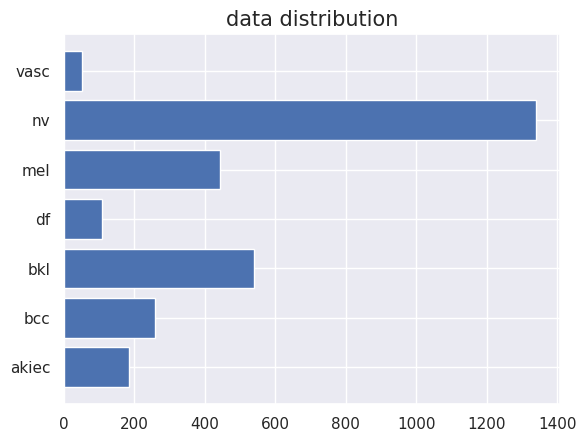

In [ ]:

## showing distribution
TargetAL = revs_label(aTARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(aIMAGES_L,np.array(aTARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
147/147 [==============================] - 5s 37ms/step - loss: 0.4320 - accuracy: 0.8755 - precision: 0.9487 - recall: 0.7441
Epoch 2/12
147/147 [==============================] - 4s 25ms/step - loss: 0.3569 - accuracy: 0.8994 - precision: 0.9400 - recall: 0.8171
Epoch 3/12
147/147 [==============================] - 4s 25ms/step - loss: 0.3011 - accuracy: 0.9161 - precision: 0.9546 - recall: 0.8393
Epoch 4/12
147/147 [==============================] - 4s 28ms/step - loss: 0.2603 - accuracy: 0.9290 - precision: 0.9481 - recall: 0.8724
Epoch 5/12
147/147 [==============================] - 4s 30ms/step - loss: 0.2462 - accuracy: 0.9328 - precision: 0.9430 - recall: 0.8973
Epoch 6/12
147/147 [==============================] - 4s 28ms/step - loss: 0.2220 - accuracy: 0.9413 - precision: 0.9507 - recall: 0.8953
Epoch 7/12
147/147 [==============================] - 4s 26ms/step - loss: 0.2020 - accuracy: 0.9488 - precision: 0.9474 - recall: 0.9164
Epoch 8/12
147/147 [==============

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

report = classification_report(TAR_Test, pred_test)
print(report)

63/63 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.42      0.48      0.45        65
           1       0.46      0.59      0.52       103
           2       0.58      0.43      0.49       220
           3       0.62      0.22      0.32        23
           4       0.47      0.41      0.44       223
           5       0.87      0.91      0.89      1341
           6       0.73      0.68      0.70        28

   micro avg       0.76      0.76      0.76      2003
   macro avg       0.59      0.53      0.54      2003
weighted avg       0.75      0.76      0.75      2003
 samples avg       0.76      0.76      0.76      2003



In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


161/161 [==============================] - 3s 19ms/step


In [ ]:
# 35% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 41% 410


In [ ]:
#GET HARDEST CLASS FROM REPORT AND AUGMENT
hard_class = get_hardest_class(report)
print("the hardest class is ",revs_label( [ np_utils.to_categorical(hard_class, 7)]))

#selecting existing data in Training set L to Augment
hc=[]
for i in range(len(TARGET_L)):
    if (TARGET_L[i][hard_class] == 1) :
        hc.append(i)
        
hc_IMAGES = IMAGES_L[hc]
hc_TAR = TARGET_L[hc]

#CREATING AUGMENTED DATA
if len(hc) < len(TARGET_L)/7:
    rate= 1
else:
    rate= 0   # no need to augment class with large ratio of data
aug_img_dic[hard_class],aug_tar_dic[hard_class] = aug_generator(hc_IMAGES,hc_TAR,rate=1)

# ADDING AGUMENTED DATASET TO CURRENT TRAINING SET L

aIMAGES_L = IMAGES_L
aTARGET_L = TARGET_L

for i in aug_img_dic.keys():
    aIMAGES_L= np.concatenate((aIMAGES_L,aug_img_dic[i]), axis=0)
    aTARGET_L= np.concatenate((aTARGET_L,aug_tar_dic[i]), axis=0)

the hardest class is  ['df']


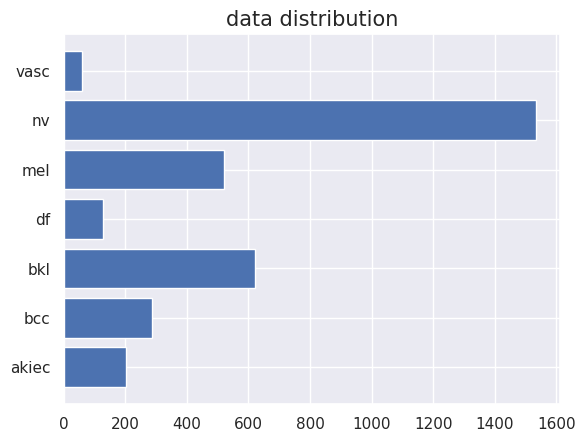

In [ ]:

## showing distribution
TargetAL = revs_label(aTARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(aIMAGES_L,np.array(aTARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
168/168 [==============================] - 6s 37ms/step - loss: 0.3928 - accuracy: 0.8851 - precision: 0.8553 - recall: 0.8910
Epoch 2/12
168/168 [==============================] - 4s 26ms/step - loss: 0.3427 - accuracy: 0.9033 - precision: 0.8740 - recall: 0.9090
Epoch 3/12
168/168 [==============================] - 4s 26ms/step - loss: 0.3398 - accuracy: 0.9006 - precision: 0.8784 - recall: 0.8988
Epoch 4/12
168/168 [==============================] - 4s 25ms/step - loss: 0.2419 - accuracy: 0.9328 - precision: 0.9233 - recall: 0.9203
Epoch 5/12
168/168 [==============================] - 4s 26ms/step - loss: 0.2382 - accuracy: 0.9349 - precision: 0.9298 - recall: 0.9137
Epoch 6/12
168/168 [==============================] - 4s 25ms/step - loss: 0.2172 - accuracy: 0.9403 - precision: 0.9100 - recall: 0.9358
Epoch 7/12
168/168 [==============================] - 4s 25ms/step - loss: 0.2127 - accuracy: 0.9427 - precision: 0.9284 - recall: 0.9248
Epoch 8/12
168/168 [==============

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

report = classification_report(TAR_Test, pred_test)
print(report)

63/63 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.37      0.20      0.26        65
           1       0.54      0.63      0.58       103
           2       0.54      0.58      0.56       220
           3       0.56      0.39      0.46        23
           4       0.60      0.43      0.50       223
           5       0.87      0.91      0.89      1341
           6       0.67      0.86      0.75        28

   micro avg       0.78      0.78      0.78      2003
   macro avg       0.59      0.57      0.57      2003
weighted avg       0.77      0.78      0.77      2003
 samples avg       0.78      0.78      0.78      2003



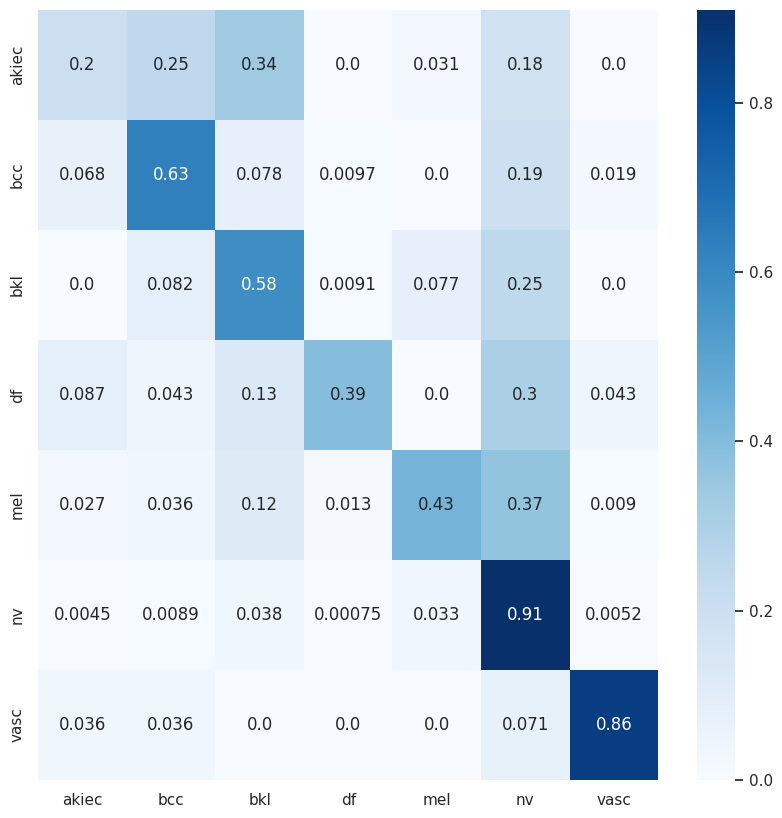

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames ) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


148/148 [==============================] - 3s 17ms/step


In [ ]:
# 40% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 46% 408


In [ ]:
#GET HARDEST CLASS FROM REPORT AND AUGMENT
hard_class = get_hardest_class(report)
print("the hardest class is ",revs_label( [ np_utils.to_categorical(hard_class, 7)]))

#selecting existing data in Training set L to Augment
hc=[]
for i in range(len(TARGET_L)):
    if (TARGET_L[i][hard_class] == 1) :
        hc.append(i)
        
hc_IMAGES = IMAGES_L[hc]
hc_TAR = TARGET_L[hc]

#CREATING AUGMENTED DATA
if len(hc) < len(TARGET_L)/7:
    rate= 1
else:
    rate= 0   # no need to augment class with large ratio of data
aug_img_dic[hard_class],aug_tar_dic[hard_class] = aug_generator(hc_IMAGES,hc_TAR,rate=1)

# ADDING AGUMENTED DATASET TO CURRENT TRAINING SET L

aIMAGES_L = IMAGES_L
aTARGET_L = TARGET_L

for i in aug_img_dic.keys():
    aIMAGES_L= np.concatenate((aIMAGES_L,aug_img_dic[i]), axis=0)
    aTARGET_L= np.concatenate((aTARGET_L,aug_tar_dic[i]), axis=0)

the hardest class is  ['akiec']


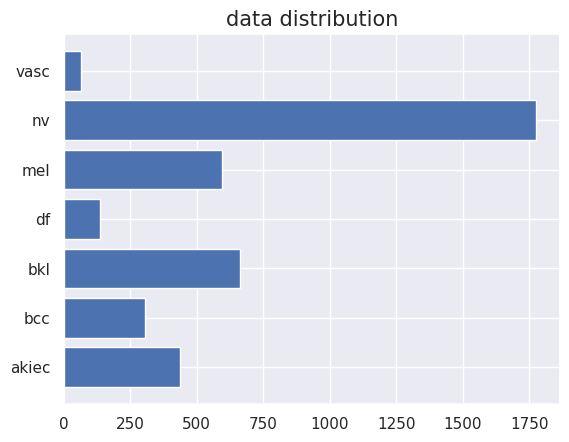

In [ ]:

## showing distribution
TargetAL = revs_label(aTARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(aIMAGES_L,np.array(aTARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
199/199 [==============================] - 6s 33ms/step - loss: 0.3921 - accuracy: 0.8886 - precision: 0.8716 - recall: 0.8755
Epoch 2/12
199/199 [==============================] - 5s 23ms/step - loss: 0.3429 - accuracy: 0.9077 - precision: 0.9029 - recall: 0.8727
Epoch 3/12
199/199 [==============================] - 5s 24ms/step - loss: 0.2977 - accuracy: 0.9170 - precision: 0.8589 - recall: 0.9371
Epoch 4/12
199/199 [==============================] - 5s 24ms/step - loss: 0.2510 - accuracy: 0.9339 - precision: 0.8803 - recall: 0.9505
Epoch 5/12
199/199 [==============================] - 5s 23ms/step - loss: 0.2442 - accuracy: 0.9303 - precision: 0.9005 - recall: 0.9401
Epoch 6/12
199/199 [==============================] - 5s 24ms/step - loss: 0.2466 - accuracy: 0.9321 - precision: 0.9326 - recall: 0.9087
Epoch 7/12
199/199 [==============================] - 5s 24ms/step - loss: 0.2369 - accuracy: 0.9376 - precision: 0.9384 - recall: 0.8934
Epoch 8/12
199/199 [==============

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

report = classification_report(TAR_Test, pred_test)
print(report)

63/63 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.34      0.58      0.43        65
           1       0.50      0.50      0.50       103
           2       0.51      0.42      0.46       220
           3       0.44      0.52      0.48        23
           4       0.50      0.43      0.46       223
           5       0.89      0.90      0.89      1341
           6       0.73      0.79      0.76        28

   micro avg       0.76      0.76      0.76      2003
   macro avg       0.56      0.59      0.57      2003
weighted avg       0.76      0.76      0.76      2003
 samples avg       0.76      0.76      0.76      2003



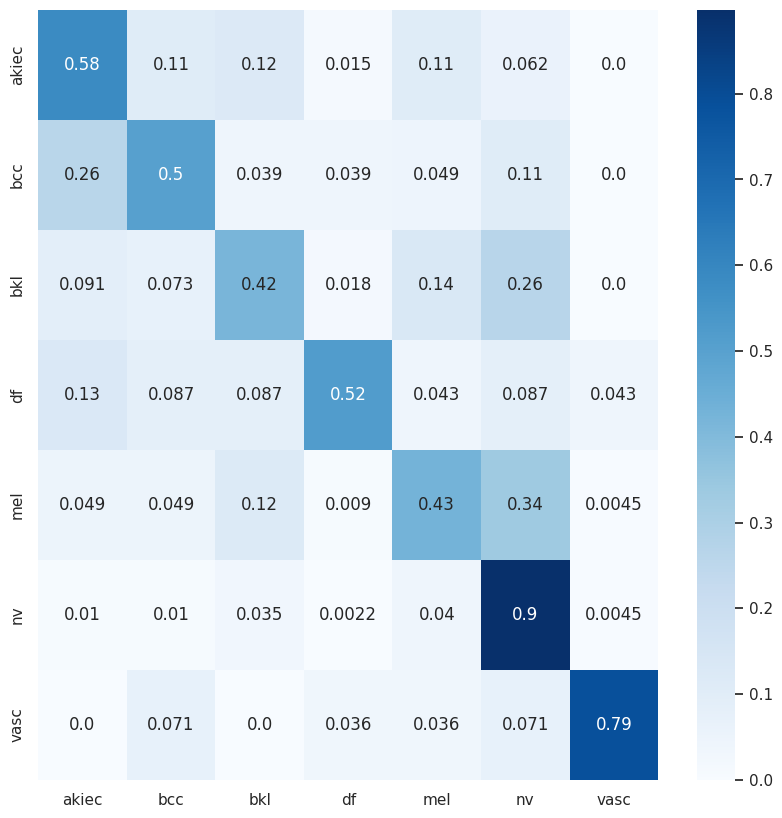

In [ ]:
plot_confusion_matrix(TAR_Test,pred_test,classNames ) 

In [ ]:
## PREDICT ON UNLABELED DATA SET WITH 10% INITIAL MODEL

predAL = modelAL.predict(IMAGES_U)
pred_test=[]
for x in predAL:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')


135/135 [==============================] - 2s 18ms/step


In [ ]:
# 45% 

# GETTING AND ADDING NEXT BATCH

batch = get_diverse_batch(5)

#Selecting new batch to concatinate to initial training set
# and correspond labels from 'Oracle
x_batch = IMAGES_U[np.array(batch)]
x_batch.shape

y = TARGET_O[np.array(batch)]
y.shape

# Adding batch and label to copy of training set
IMAGES_L = np.concatenate((IMAGES_L, x_batch), axis=0)
TARGET_L= np.concatenate((TARGET_L, y), axis=0)

# removing x_batch from unlabel test set
IMAGES_U = np.delete(IMAGES_U,batch,axis=0)
TARGET_O =   np.delete(TARGET_O,batch,axis=0)

print("RANDOM SAMPLED NOW TRAINING SET AT {}%".format(round(len(IMAGES_L)/len(IMAGES)*100)),len(batch))

RANDOM SAMPLED NOW TRAINING SET AT 51% 409


In [ ]:
#GET HARDEST CLASS FROM REPORT AND AUGMENT
hard_class = get_hardest_class(report)
print("the hardest class is ",revs_label( [ np_utils.to_categorical(hard_class, 7)]))

#selecting existing data in Training set L to Augment
hc=[]
for i in range(len(TARGET_L)):
    if (TARGET_L[i][hard_class] == 1) :
        hc.append(i)
        
hc_IMAGES = IMAGES_L[hc]
hc_TAR = TARGET_L[hc]

#CREATING AUGMENTED DATA
if len(hc) < len(TARGET_L)/7:
    rate= 1
else:
    rate= 0   # no need to augment class with large ratio of data
aug_img_dic[hard_class],aug_tar_dic[hard_class] = aug_generator(hc_IMAGES,hc_TAR,rate=1)

# ADDING AGUMENTED DATASET TO CURRENT TRAINING SET L

aIMAGES_L = IMAGES_L
aTARGET_L = TARGET_L

for i in aug_img_dic.keys():
    aIMAGES_L= np.concatenate((aIMAGES_L,aug_img_dic[i]), axis=0)
    aTARGET_L= np.concatenate((aTARGET_L,aug_tar_dic[i]), axis=0)

the hardest class is  ['akiec']


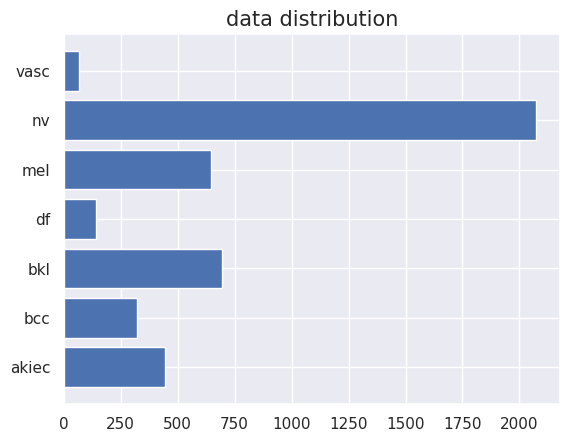

In [ ]:

## showing distribution
TargetAL = revs_label(aTARGET_L)
parts = np.unique(TargetAL)
count=[]
for part in parts:
    count.append(TargetAL.count(part))
plt.barh(parts,count)
plt.title("data distribution",size = 15)
plt.show()

In [ ]:
# TRAINING
modelAL.fit(aIMAGES_L,np.array(aTARGET_L),batch_size=20, epochs=12,verbose=1) # based on tutorial epochs == 6 was the optimal resnet elbow


Epoch 1/12
220/220 [==============================] - 7s 32ms/step - loss: 0.2348 - accuracy: 0.9380 - precision: 0.9303 - recall: 0.9248
Epoch 2/12
220/220 [==============================] - 5s 24ms/step - loss: 0.2471 - accuracy: 0.9323 - precision: 0.9170 - recall: 0.9184
Epoch 3/12
220/220 [==============================] - 5s 24ms/step - loss: 0.2135 - accuracy: 0.9437 - precision: 0.9289 - recall: 0.9291
Epoch 4/12
220/220 [==============================] - 5s 23ms/step - loss: 0.2263 - accuracy: 0.9378 - precision: 0.9426 - recall: 0.8947
Epoch 5/12
220/220 [==============================] - 5s 24ms/step - loss: 0.1936 - accuracy: 0.9483 - precision: 0.9470 - recall: 0.9205
Epoch 6/12
220/220 [==============================] - 5s 24ms/step - loss: 0.2261 - accuracy: 0.9348 - precision: 0.9286 - recall: 0.9095
Epoch 7/12
220/220 [==============================] - 5s 23ms/step - loss: 0.1656 - accuracy: 0.9549 - precision: 0.9221 - recall: 0.9576
Epoch 8/12
220/220 [==============

In [ ]:
# TESTING
predAL = modelAL.predict(IMAGES_Test)
pred_test=[]
for x in predAL:
    pred_test.append([1 if i==max(x) else 0 for i in x ])
pred_test = np.array(pred_test,dtype='float32')

report = classification_report(TAR_Test, pred_test)
print(report)

63/63 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.39      0.45      0.41        65
           1       0.55      0.58      0.57       103
           2       0.67      0.38      0.49       220
           3       0.68      0.57      0.62        23
           4       0.43      0.62      0.50       223
           5       0.90      0.89      0.89      1341
           6       0.89      0.57      0.70        28

   micro avg       0.77      0.77      0.77      2003
   macro avg       0.64      0.58      0.60      2003
weighted avg       0.78      0.77      0.77      2003
 samples avg       0.77      0.77      0.77      2003



##### REPEAT